# Multi-Sensor Lake Ice Phenology Detection
## Alaska Thermokarst Lakes - Sentinel-1 + Sentinel-2 + ERA5 Approach

**Goal:** Detect ice-on and ice-off dates for ~550 Alaska lakes using multi-sensor fusion

**Approach:**
1. Use Sentinel-2 NDSI as high-confidence ground truth (when clouds permit, and excluding summer algal blooms)
2. Train Random Forest on S1 features using S2 labels
3. Use trained model to interpolate between S2 observations
4. Apply ERA5 temperature constraints to filter out anomalous summer S2
5. Detect ice-on/ice-off transitions with confidence scoring

**Based on:** [Tom et al. (2020)](https://isprs-annals.copernicus.org/articles/V-3-2020/409/2020/isprs-annals-V-3-2020-409-2020.pdf) - using optical data to train SAR interpretation

---
## Part 1: Setup and Configuration

In [3]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Initialize Earth Engine
ee.Initialize()

print("Imports successful!")
print(f"Earth Engine initialized: {ee.String('GEE Initialized').getInfo()}")

httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


Imports successful!
Earth Engine initialized: GEE Initialized


In [4]:
# Configuration
YEAR = 2023
BUCKET = 'wustl-eeps-geospatial'
LAKE_ASSET = 'projects/eeps-geospatial/assets/alaska_lakes' 
LAKE_ID_FIELD = 'id'
SCALE = 10  # Sentinel-1 resolution

# Alaska Albers projection
proj_ak = ee.Projection('EPSG:3338')

print(f"Configuration set for year {YEAR}")
print(f"Will export to gs://{BUCKET}/thermokarst_lakes/")

Configuration set for year 2023
Will export to gs://wustl-eeps-geospatial/thermokarst_lakes/


---
## Part 2: Load and Prepare Lake Geometries

In [63]:
# Load lakes
lakes = ee.FeatureCollection(LAKE_ASSET)
print(f"Loaded {lakes.size().getInfo()} lakes")

# Add geometry metrics
def add_geom_metrics(feat):
    geom = feat.geometry().transform(proj_ak, 1)
    area = geom.area(1)
    perim = geom.perimeter(1)
    centroid = geom.centroid(1)
    coords = centroid.coordinates()
    
    # Existing metrics
    circularity = ee.Number(4).multiply(ee.Number(np.pi)).multiply(area).divide(perim.pow(2))
    
    # Fractal dimension approximation (perimeter-area relationship)
    # D = 2 * ln(perimeter/4) / ln(area)
    fractal_dim = ee.Number(2).multiply(
        perim.divide(4).log().divide(area.log())
    )
    
    # Convexity
    convex_hull = geom.convexHull(1)
    convex_area = convex_hull.area(1)
    convexity = area.divide(convex_area)
    
    return feat.set({
        'lake_area_m2': area,
        'lake_perim_m': perim,
        'circularity': circularity,
        'fractal_dim': fractal_dim,
        'convexity': convexity,
        'centroid_lon': coords.get(0),
        'centroid_lat': coords.get(1)
    })

lakes_with_geom = lakes.map(add_geom_metrics)

# Create buffered lake interiors
def buffer_interior(feat):
    geom = feat.geometry()
    area = geom.area()
    
    # Use fixed 10m negative buffer - 67% approach was too aggressive on small lakes
    buffered = geom.buffer(-10)
    # For very small lakes, use original geometry
    buffered = ee.Algorithms.If(
        area.lt(10000),  # If lake < 10,000 m² (0.01 km²)
        geom,            # Use full lake
        buffered         # Otherwise use 10m buffer
    )   
    return feat.setGeometry(ee.Geometry(buffered))

lakes_buf = lakes_with_geom.map(buffer_interior)

# Create landscape rings (100m around lakes)
def create_landscape_ring(feat):
    lake_geom = feat.geometry()
    outer_buffer = lake_geom.buffer(100)
    ring = outer_buffer.difference(lake_geom)
    return feat.setGeometry(ring)

landscape_rings = lakes_with_geom.map(create_landscape_ring)

print("Lake geometries prepared:")
print("  - Original lakes")
print("  - Buffered interiors (10m)")
print("  - Landscape rings (100m)")

Loaded 541 lakes
Lake geometries prepared:
  - Original lakes
  - Buffered interiors (10m)
  - Landscape rings (100m)


---
## Part 3: Define Data Collection Functions

In [6]:
# Sentinel-1 collection
def get_s1_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    coll = (ee.ImageCollection('COPERNICUS/S1_GRD')
            .filterBounds(lakes.geometry())
            .filterDate(start, end)
            .filter(ee.Filter.eq('instrumentMode', 'IW'))
            .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
            .filter(ee.Filter.eq('resolution_meters', 10)))
    
    def prep_s1(img):
        angle = img.select('angle')
        angle_mask = angle.gt(25).And(angle.lt(50))
        
        # Process VV
        vv_lin = ee.Image(10.0).pow(img.select('VV').divide(10.0)).updateMask(angle_mask)
        vv_lin_f = vv_lin.focal_mean(1)
        vv_db = vv_lin_f.log10().multiply(10).rename('VV_db')
        
        # Process VH
        vh_lin = ee.Image(10.0).pow(img.select('VH').divide(10.0)).updateMask(angle_mask)
        vh_lin_f = vh_lin.focal_mean(1)
        vh_db = vh_lin_f.log10().multiply(10).rename('VH_db')
        
        return vv_db.addBands(vh_db).copyProperties(img, img.propertyNames())
    
    return coll.map(prep_s1)

# Sentinel-2 collection with pixel-level cloud masking
def get_s2_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    coll = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterBounds(lakes.geometry())
            .filterDate(start, end)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)))  # Relaxed from 30% to 50%
    
    def compute_ndsi(img):
        # Use QA60 to mask clouds at pixel level
        qa = img.select('QA60')
        cloud_bit_mask = 1 << 10
        cirrus_bit_mask = 1 << 11
        
        # Mask clouds and cirrus
        mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
               qa.bitwiseAnd(cirrus_bit_mask).eq(0))
        
        # NDSI = (Green - SWIR1) / (Green + SWIR1)
        ndsi = img.normalizedDifference(['B3', 'B11']).rename('ndsi').updateMask(mask)
        # Ice mask: NDSI > 0.4
        ice_mask = ndsi.gt(0.4).rename('ice')
        
        return img.addBands(ndsi).addBands(ice_mask)
    
    return coll.map(compute_ndsi)

# ERA5 temperature collection
def get_era5_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    # Get daily mean temperature
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate(start, end).select('temperature_2m')
    
    # Convert to daily means
    days = ee.List.sequence(0, 364)  # 365 days
    
    def daily_mean(day):
        date = start.advance(day, 'day')
        daily = era5.filterDate(date, date.advance(1, 'day')).mean()
        # Convert Kelvin to Celsius
        temp_c = daily.subtract(273.15).rename('temp_c')
        return temp_c.set('system:time_start', date.millis())
    
    return ee.ImageCollection.fromImages(days.map(daily_mean))

print("Data collection functions defined")

Data collection functions defined


---
## Part 4: Export Multi-Sensor Data

This will export three separate CSVs:
1. Sentinel-1 time series (VV, VH, RGB features)
2. Sentinel-2 time series (NDSI, ice fraction)
3. ERA5 daily temperature

We'll merge them later in Python.

In [20]:
# Load collections
s1 = get_s1_collection(YEAR)
s2 = get_s2_collection(YEAR)
era5 = get_era5_collection(YEAR)

print(f"S1 images: {s1.size().getInfo()}")
print(f"S2 images: {s2.size().getInfo()}")
print(f"ERA5 daily images: {era5.size().getInfo()}")

S1 images: 28
S2 images: 475
ERA5 daily images: 365


### Export 1: Sentinel-1 Data

In [18]:
def s1_to_features(img):
    vv_img = img.select('VV_db')
    vh_img = img.select('VH_db')
    
    # RGB bands - FIXED adaptive scaling
    r_band = vv_img.unitScale(-20, -5).multiply(255).byte().rename('R')
    g_band = vh_img.unitScale(-28, -12).multiply(255).byte().rename('G')
    b_band = vv_img.subtract(vh_img).unitScale(8, 18).multiply(255).byte().rename('B')
    
    rgb_img = ee.Image.cat([r_band, g_band, b_band])
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    
    # Reducers
    vv_reducer = ee.Reducer.mean().combine(ee.Reducer.count(), sharedInputs=True)
    vh_reducer = ee.Reducer.mean()
    rgb_reducer = ee.Reducer.mean()
    
    # Reduce over lake interiors
    vv_stats = vv_img.reduceRegions(
        collection=lakes_buf,
        reducer=vv_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    vh_stats = vh_img.reduceRegions(
        collection=lakes_buf,
        reducer=vh_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    rgb_stats = rgb_img.reduceRegions(
        collection=lakes_buf,
        reducer=rgb_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    # Landscape context
    land_stats = rgb_img.reduceRegions(
        collection=landscape_rings,
        reducer=rgb_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    def add_metadata(f):
        lake_id_prop = f.get(LAKE_ID_FIELD)
        
        # Get stats for this lake
        vh_feature = vh_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        rgb_feature = rgb_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        land_feature = land_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        # Get geometry metrics from original
        orig = lakes_with_geom.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        # FIXED: Handle null VH values safely
        vv_val = ee.Number(f.get('mean'))
        vh_val = ee.Number(vh_feature.get('mean'))
        
        # Only compute ratio if both values exist
        vv_vh_ratio = ee.Algorithms.If(
            vh_feature.get('mean'),  # Check if VH exists
            vv_val.subtract(vh_val),  # Compute if exists
            ee.Number(-999)  # Null flag if missing
        )
        
        return (f.set('date', date_str)
                .set('sensor', 'S1')
                .set('vv_db', vv_val)
                .set('vh_db', vh_val)
                .set('vv_vh_ratio', vv_vh_ratio)
                .set('lake_R', rgb_feature.get('R'))
                .set('lake_G', rgb_feature.get('G'))
                .set('lake_B', rgb_feature.get('B'))
                .set('land_R', land_feature.get('R'))
                .set('land_G', land_feature.get('G'))
                .set('land_B', land_feature.get('B'))
                .set('lake_area_m2', orig.get('lake_area_m2'))
                .set('centroid_lon', orig.get('centroid_lon'))
                .set('centroid_lat', orig.get('centroid_lat'))
                .set('lake_id', ee.Number(lake_id_prop).toInt()))
    
    return vv_stats.map(add_metadata)

# Map over S1 images
s1_features = s1.map(s1_to_features).flatten()

# Export
s1_cols = [
    'lake_id', 'date', 'sensor',
    'vv_db', 'vh_db', 'vv_vh_ratio',
    'lake_R', 'lake_G', 'lake_B',
    'land_R', 'land_G', 'land_B',
    'lake_area_m2', 'centroid_lon', 'centroid_lat'
]

task_s1 = ee.batch.Export.table.toCloudStorage(
    collection=s1_features.select(s1_cols),
    description=f'Alaska_Lakes_S1_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_S1_{YEAR}',
    fileFormat='CSV',
    selectors=s1_cols
)

task_s1.start()
print(f"Started S1 export: {task_s1.id}")

Started S1 export: QPCJFGX3PB67S25CGEHKTK3J


### Export 2: Sentinel-2 Data

In [21]:
def s2_to_features(img):
    """
    Only export S2 data for lakes that this image actually covers
    """
    ice_img = img.select('ice')
    ndsi_img = img.select('ndsi')
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    
    # KEY FIX: Only process lakes that intersect this image's footprint
    img_bounds = img.geometry()
    lakes_in_image = lakes_buf.filterBounds(img_bounds)
    
    # Reduce over lake interiors (only those in this image)
    ice_stats = ice_img.reduceRegions(
        collection=lakes_in_image,  # Only lakes covered by this image
        reducer=ee.Reducer.mean(),
        scale=20,  # S2 SWIR resolution
        tileScale=2
    )
    
    ndsi_stats = ndsi_img.reduceRegions(
        collection=lakes_in_image,  # Only lakes covered by this image
        reducer=ee.Reducer.mean(),
        scale=20,
        tileScale=2
    )
    
    def add_metadata(f):
        lake_id_prop = f.get(LAKE_ID_FIELD)
        ndsi_feature = ndsi_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        orig = lakes_with_geom.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        return (f.set('date', date_str)
                .set('sensor', 'S2')
                .set('ice_fraction', f.get('mean'))  # Fraction of pixels with ice
                .set('ndsi_mean', ndsi_feature.get('mean'))
                .set('lake_area_m2', orig.get('lake_area_m2'))
                .set('centroid_lon', orig.get('centroid_lon'))
                .set('centroid_lat', orig.get('centroid_lat'))
                .set('lake_id', ee.Number(lake_id_prop).toInt()))
    
    return ice_stats.map(add_metadata)

# Map over S2 images
s2_features = s2.map(s2_to_features).flatten()

# Export
s2_cols = [
    'lake_id', 'date', 'sensor',
    'ice_fraction', 'ndsi_mean',
    'lake_area_m2', 'centroid_lon', 'centroid_lat'
]

task_s2 = ee.batch.Export.table.toCloudStorage(
    collection=s2_features.select(s2_cols),
    description=f'Alaska_Lakes_S2_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_S2_{YEAR}',
    fileFormat='CSV',
    selectors=s2_cols
)

task_s2.start()
print(f"Started S2 export: {task_s2.id}")

Started S2 export: UJNBV53OYRYIVD4PWEYO4W26


### Export 3: ERA5 Temperature Data

In [11]:
# Get ERA5 as daily image collection
def get_era5_daily_grid(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate(start, end).select('temperature_2m')
    
    # Create daily means
    days = ee.List.sequence(0, 364)
    
    def daily_mean(day):
        date = start.advance(day, 'day')
        daily = era5.filterDate(date, date.advance(1, 'day')).mean()
        temp_c = daily.subtract(273.15).rename('temp_c')
        return temp_c.set('system:time_start', date.millis()).set('date', date.format('YYYY-MM-dd'))
    
    return ee.ImageCollection.fromImages(days.map(daily_mean))

era5_daily = get_era5_daily_grid(YEAR)

# Create point features at lake centroids
lake_points = lakes_with_geom.map(
    lambda f: ee.Feature(
        f.geometry().centroid(),
        {
            'lake_id': f.get(LAKE_ID_FIELD),
            'centroid_lon': f.get('centroid_lon'),
            'centroid_lat': f.get('centroid_lat')
        }
    )
)

print(f"Created {lake_points.size().getInfo()} lake centroid points")

# Sample temperature at each lake centroid for each day
def sample_at_lakes(img):
    date_str = img.get('date')
    
    # Sample at points (much faster than reduceRegions)
    samples = img.select('temp_c').sampleRegions(
        collection=lake_points,
        scale=11000,
        geometries=False
    )
    
    # Add date to each sample
    def add_date(f):
        return f.set('date', date_str).set('sensor', 'ERA5')
    
    return samples.map(add_date)

print("Sampling ERA5 at lake centroids...")
era5_features = era5_daily.map(sample_at_lakes).flatten()

# Export
era5_cols = ['lake_id', 'date', 'sensor', 'temp_c', 'centroid_lon', 'centroid_lat']

task_era5 = ee.batch.Export.table.toCloudStorage(
    collection=era5_features.select(era5_cols),
    description=f'Alaska_Lakes_ERA5_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_ERA5_{YEAR}',
    fileFormat='CSV',
    selectors=era5_cols
)

task_era5.start()
print(f"Started ERA5 export: {task_era5.id}")

httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


Created 541 lake centroid points
Sampling ERA5 at lake centroids...
Started ERA5 export: C6WB4F4FMQGSDGF6B25EHQOJ


In [9]:
print("\n" + "="*60)
print("ALL EXPORTS STARTED")
print("="*60)
print(f"S1 task:   {task_s1.id}")
print(f"S2 task:   {task_s2.id}")
print(f"ERA5 task: {task_era5.id}")
print("\nEstimated completion time:")
print("  - S1:   60-90 minutes")
print("  - S2:   30-60 minutes")
print("  - ERA5: 90-120 minutes")
print("\nCheck status at: https://code.earthengine.google.com/tasks")
print("\nOnce complete, download CSVs from GCS bucket and continue to Part 5")


ALL EXPORTS STARTED
S1 task:   OAWAKGBTBPMXTA7WRMA4UHSJ
S2 task:   D6LSA5YNA3GPMETGI5XDXQP5
ERA5 task: X2NXEUY2ORZLPENWUADWBHOJ

Estimated completion time:
  - S1:   60-90 minutes
  - S2:   30-60 minutes
  - ERA5: 90-120 minutes

Check status at: https://code.earthengine.google.com/tasks

Once complete, download CSVs from your GCS bucket and continue to Part 5


---
## Part 5: Load and Merge Multi-Sensor Data

**Run this section after exports complete and CSVs are downloaded**

In [39]:
# Load the three CSVs
df_s1 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_S1_2023.csv')
df_s2 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_S2_2023.csv')
df_era5 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_ERA5_2023.csv')

# Convert dates
df_s1['date'] = pd.to_datetime(df_s1['date'])
df_s2['date'] = pd.to_datetime(df_s2['date'])
df_era5['date'] = pd.to_datetime(df_era5['date'])

print("Data loaded:")
print(f"  S1:   {len(df_s1):,} observations across {df_s1['lake_id'].nunique()} lakes")
print(f"  S2:   {len(df_s2):,} observations across {df_s2['lake_id'].nunique()} lakes")
print(f"  ERA5: {len(df_era5):,} observations across {df_era5['lake_id'].nunique()} lakes")

# Merge S1 + temperature (every S1 obs gets a temp)
df_s1 = df_s1.merge(df_era5[['lake_id', 'date', 'temp_c']], on=['lake_id', 'date'], how='left')

print(f"\nMerged S1 + temperature: {len(df_s1):,} observations")
print(f"Temperature coverage: {df_s1['temp_c'].notna().sum() / len(df_s1) * 100:.1f}%")

Data loaded:
  S1:   15,148 observations across 541 lakes
  S2:   64,499 observations across 541 lakes
  ERA5: 191,625 observations across 525 lakes

Merged S1 + temperature: 15,148 observations
Temperature coverage: 97.0%


In [40]:
# Deduplicate: keep only one S2 observation per lake per date
print(f"Before deduplication: {len(df_s2):,} rows")

# For duplicates, keep the one with highest ice_fraction confidence (furthest from 0.5)
df_s2['confidence'] = (df_s2['ice_fraction'] - 0.5).abs()
df_s2 = df_s2.sort_values('confidence', ascending=False).drop_duplicates(
    subset=['lake_id', 'date'], 
    keep='first'
)
df_s2 = df_s2.drop(columns='confidence')

print(f"After deduplication:  {len(df_s2):,} rows")
print(f"Removed {64499 - len(df_s2):,} duplicate observations")

# Recompute ice state
df_s2['s2_ice_state'] = 'PARTIAL'
df_s2.loc[df_s2['ice_fraction'] > 0.8, 's2_ice_state'] = 'ICE'
df_s2.loc[df_s2['ice_fraction'] < 0.2, 's2_ice_state'] = 'WATER'

Before deduplication: 64,499 rows
After deduplication:  37,368 rows
Removed 27,131 duplicate observations


In [41]:
# S2 coverage statistics
print("\nSentinel-2 Coverage Analysis:")
print("="*60)

s2_per_lake = df_s2.groupby('lake_id').size()
print(f"S2 observations per lake:")
print(f"  Mean:   {s2_per_lake.mean():.1f}")
print(f"  Median: {s2_per_lake.median():.0f}")
print(f"  Min:    {s2_per_lake.min():.0f}")
print(f"  Max:    {s2_per_lake.max():.0f}")

# CRITICAL: Merge temperature onto S2 data for label cleaning
print("\nMerging temperature data onto S2 observations...")
df_s2 = df_s2.merge(df_era5[['lake_id', 'date', 'temp_c']], 
                    on=['lake_id', 'date'], how='left')
print(f"Temperature coverage in S2 data: {df_s2['temp_c'].notna().sum() / len(df_s2) * 100:.1f}%")

# Add month for diagnostics
df_s2['month'] = df_s2['date'].dt.month

# Compute 7-day rolling mean temperature for each lake
print("\nComputing 7-day temperature trends...")
df_s2 = df_s2.sort_values(['lake_id', 'date'])
df_s2['temp_7day_mean'] = df_s2.groupby('lake_id')['temp_c'].transform(
    lambda x: x.rolling(window=7, min_periods=3, center=False).mean()
)

# Create initial ice state labels from S2
df_s2['s2_ice_state'] = 'PARTIAL'
df_s2.loc[df_s2['ice_fraction'] > 0.6, 's2_ice_state'] = 'ICE'    
df_s2.loc[df_s2['ice_fraction'] < 0.4, 's2_ice_state'] = 'WATER'

print(f"\nInitial S2 ice classification (before temperature filtering):")
print(df_s2['s2_ice_state'].value_counts())

# Apply temperature trend constraints (not single-day)
ice_labels = df_s2['s2_ice_state'] == 'ICE'
water_labels = df_s2['s2_ice_state'] == 'WATER'
temp_7day_available = df_s2['temp_7day_mean'].notna()

# Sustained warm period -> ice impossible
# 7-day mean > 10°C means consistent warmth, ice should have melted
impossible_ice_warm_trend = (ice_labels & temp_7day_available & 
                             (df_s2['temp_7day_mean'] > 5))

# Sustained cold period -> water impossible  
# 7-day mean < -5°C means consistent cold, water should have frozen
impossible_water_cold_trend = (water_labels & temp_7day_available & 
                               (df_s2['temp_7day_mean'] < -5))

df_s2.loc[impossible_ice_warm_trend, 's2_ice_state'] = 'WATER'
df_s2.loc[impossible_water_cold_trend, 's2_ice_state'] = 'ICE'

print(f"\nCleaned S2 ice classification (after 7-day temperature trend filtering):")
print(df_s2['s2_ice_state'].value_counts())
print(f"  Overridden as WATER (7-day mean temp > 10°C): {impossible_ice_warm_trend.sum()}")
print(f"  Overridden as ICE (7-day mean temp < -5°C): {impossible_water_cold_trend.sum()}")
print(f"\nClear detections (ICE or WATER): {((df_s2['s2_ice_state'] == 'ICE') | (df_s2['s2_ice_state'] == 'WATER')).sum() / len(df_s2) * 100:.1f}%")


Sentinel-2 Coverage Analysis:
S2 observations per lake:
  Mean:   69.1
  Median: 70
  Min:    48
  Max:    106

Merging temperature data onto S2 observations...
Temperature coverage in S2 data: 97.0%

Computing 7-day temperature trends...

Initial S2 ice classification (before temperature filtering):
s2_ice_state
ICE        24264
WATER      12242
PARTIAL      862
Name: count, dtype: int64

Cleaned S2 ice classification (after 7-day temperature trend filtering):
s2_ice_state
ICE        22119
WATER      14387
PARTIAL      862
Name: count, dtype: int64
  Overridden as WATER (7-day mean temp > 10°C): 2341
  Overridden as ICE (7-day mean temp < -5°C): 196

Clear detections (ICE or WATER): 97.7%


In [42]:
# DIAGNOSTIC: Identify remaining suspicious summer ice detections
print("\n" + "="*60)
print("DIAGNOSTIC: Summer Ice Detection Quality Check")
print("="*60)

summer_months = df_s2['date'].dt.month.isin([6, 7, 8])
has_ice = df_s2['ice_fraction'] > 0.2
warm_temp = df_s2['temp_c'] > 5

suspicious_summer = df_s2[summer_months & has_ice & warm_temp].copy()

print(f"\nSuspicious summer 'ice' detections (Jun-Aug, ice_fraction>0.2, temp>5°C):")
print(f"  Total observations: {len(suspicious_summer)}")
if len(suspicious_summer) > 0:
    print(f"  Mean ice_fraction: {suspicious_summer['ice_fraction'].mean():.2f}")
    print(f"  Mean temperature: {suspicious_summer['temp_c'].mean():.1f}°C")
    print(f"  Mean NDSI: {suspicious_summer['ndsi_mean'].mean():.2f}")
    
    print("\n  Sample of suspicious detections:")
    sample = suspicious_summer[['lake_id', 'date', 'ice_fraction', 'ndsi_mean', 'temp_c', 's2_ice_state']].head(10)
    print(sample.to_string(index=False))
    
    # Check if temperature filtering caught most of them
    still_labeled_ice = (suspicious_summer['s2_ice_state'] == 'ICE').sum()
    print(f"\n  Still labeled as ICE after temperature filtering: {still_labeled_ice}")
    print(f"  Successfully relabeled as WATER: {len(suspicious_summer) - still_labeled_ice}")
else:
    print("  None found - temperature filtering working well!")


DIAGNOSTIC: Summer Ice Detection Quality Check

Suspicious summer 'ice' detections (Jun-Aug, ice_fraction>0.2, temp>5°C):
  Total observations: 3702
  Mean ice_fraction: 0.69
  Mean temperature: 12.4°C
  Mean NDSI: 0.48

  Sample of suspicious detections:
 lake_id       date  ice_fraction  ndsi_mean    temp_c s2_ice_state
  497058 2023-06-06      0.950000   0.605565  7.445585          ICE
  497058 2023-06-25      0.209211   0.003805 13.571739        WATER
  497058 2023-06-30      0.209211   0.315300  6.003158        WATER
  497058 2023-07-18      0.209211   0.185265  6.726949        WATER
  497058 2023-07-25      0.209211   0.124781  9.339777        WATER
  497058 2023-07-26      0.209211   0.215402 10.494336        WATER
  497058 2023-07-27      0.209211   0.283814  9.472608        WATER
  497058 2023-08-05      0.209211   0.180972 12.997539        WATER
  497058 2023-08-06      0.209211   0.250535 18.145522        WATER
  497058 2023-08-20      0.209211   0.242093  6.701411        W

---
## Part 6: Train Random Forest Using S2 Labels

Find S1-S2 pairs (within ±3 days) and use S2 ice classification as training labels for S1 features

In [43]:
# Find S1-S2 pairs within ±3 days
def find_s2_label(row, s2_data, max_days=3):
    """
    For a given S1 observation, find the closest S2 observation within max_days
    """
    lake_s2 = s2_data[s2_data['lake_id'] == row['lake_id']].copy()
    if len(lake_s2) == 0:
        return None
    
    # Calculate time difference
    lake_s2['time_diff'] = abs((lake_s2['date'] - row['date']).dt.total_seconds() / 86400)
    
    # Find closest within max_days
    close = lake_s2[lake_s2['time_diff'] <= max_days]
    if len(close) == 0:
        return None
    
    closest = close.loc[close['time_diff'].idxmin()]
    return closest['s2_ice_state']

print("Finding S1-S2 pairs...")
df_s1['s2_label'] = df_s1.apply(lambda row: find_s2_label(row, df_s2), axis=1)

# Filter to rows with S2 labels and clear ice/water classification
df_training = df_s1[df_s1['s2_label'].isin(['ICE', 'WATER'])].copy()

print(f"\nTraining data created:")
print(f"  Total S1 observations: {len(df_s1):,}")
print(f"  With S2 labels: {len(df_training):,} ({len(df_training)/len(df_s1)*100:.1f}%)")
print(f"\nLabel distribution:")
print(df_training['s2_label'].value_counts())

Finding S1-S2 pairs...

Training data created:
  Total S1 observations: 15,148
  With S2 labels: 8,393 (55.4%)

Label distribution:
s2_label
ICE      4690
WATER    3703
Name: count, dtype: int64


In [44]:
# Add z-score features to training data
print("Computing lake-relative z-scores for training data...")

z_score_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']

for col in z_score_cols:
    df_training[f'{col}_zscore'] = df_training.groupby('lake_id')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

# Prepare features and labels
feature_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 
                'land_R', 'land_G', 'land_B']

# Add z-score features
feature_cols_with_zscore = feature_cols + [f'{col}_zscore' for col in z_score_cols]

print(f"\nTotal features: {len(feature_cols_with_zscore)}")
print(f"  Original: {feature_cols}")
print(f"  Z-scores: {[f'{col}_zscore' for col in z_score_cols]}")

# Drop rows with missing features
df_training = df_training.dropna(subset=feature_cols_with_zscore)

X = df_training[feature_cols_with_zscore]  # ← Now uses both original + z-scores
y = df_training['s2_label']

# Convert labels to binary: ICE=1, WATER=0
y_binary = (y == 'ICE').astype(int)

print(f"\nTraining set: {len(X):,} samples with {len(feature_cols_with_zscore)} features")

Computing lake-relative z-scores for training data...

Total features: 18
  Original: ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']
  Z-scores: ['vv_db_zscore', 'vh_db_zscore', 'vv_vh_ratio_zscore', 'lake_R_zscore', 'lake_G_zscore', 'lake_B_zscore', 'land_R_zscore', 'land_G_zscore', 'land_B_zscore']

Training set: 8,393 samples with 18 features


In [45]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

print(f"Train set: {len(X_train):,} samples")
print(f"Test set:  {len(X_test):,} samples")

# Train Random Forest
print("\nTraining Random Forest classifier...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Training complete!")

Train set: 5,875 samples
Test set:  2,518 samples

Training Random Forest classifier...
Training complete!



RANDOM FOREST PERFORMANCE

Accuracy: 0.935

Classification Report:
              precision    recall  f1-score   support

       WATER       0.89      0.97      0.93      1111
         ICE       0.98      0.91      0.94      1407

    accuracy                           0.93      2518
   macro avg       0.93      0.94      0.93      2518
weighted avg       0.94      0.93      0.94      2518



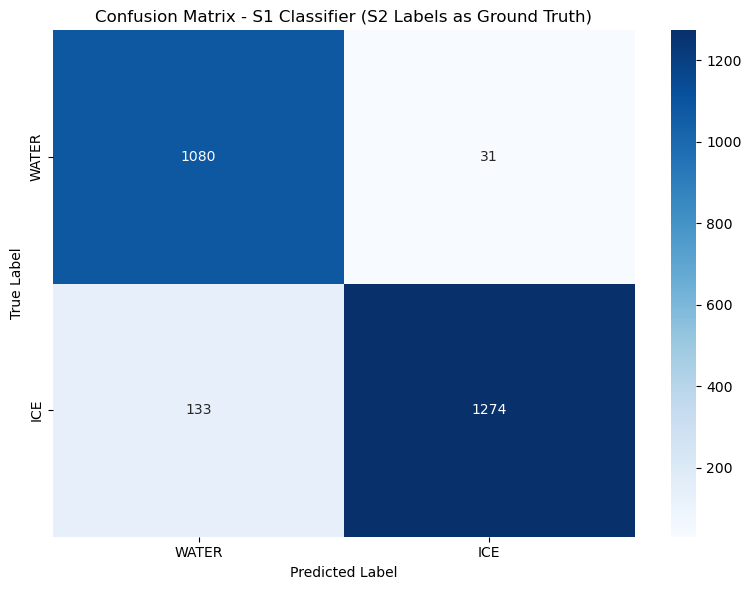


Saved: rf_confusion_matrix.png


In [46]:
# Evaluate on test set
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("RANDOM FOREST PERFORMANCE")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['WATER', 'ICE']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WATER', 'ICE'], yticklabels=['WATER', 'ICE'])
plt.title('Confusion Matrix - S1 Classifier (S2 Labels as Ground Truth)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: rf_confusion_matrix.png")


Feature Importance:
           feature  importance
     land_G_zscore    0.282767
     land_R_zscore    0.229422
            land_G    0.209944
            land_R    0.122152
     land_B_zscore    0.035256
     lake_G_zscore    0.019750
            land_B    0.017529
             vv_db    0.014351
     lake_R_zscore    0.010092
             vh_db    0.010043
      vh_db_zscore    0.009899
            lake_R    0.009303
            lake_G    0.007073
      vv_db_zscore    0.005854
     lake_B_zscore    0.005633
            lake_B    0.005375
vv_vh_ratio_zscore    0.003091
       vv_vh_ratio    0.002467


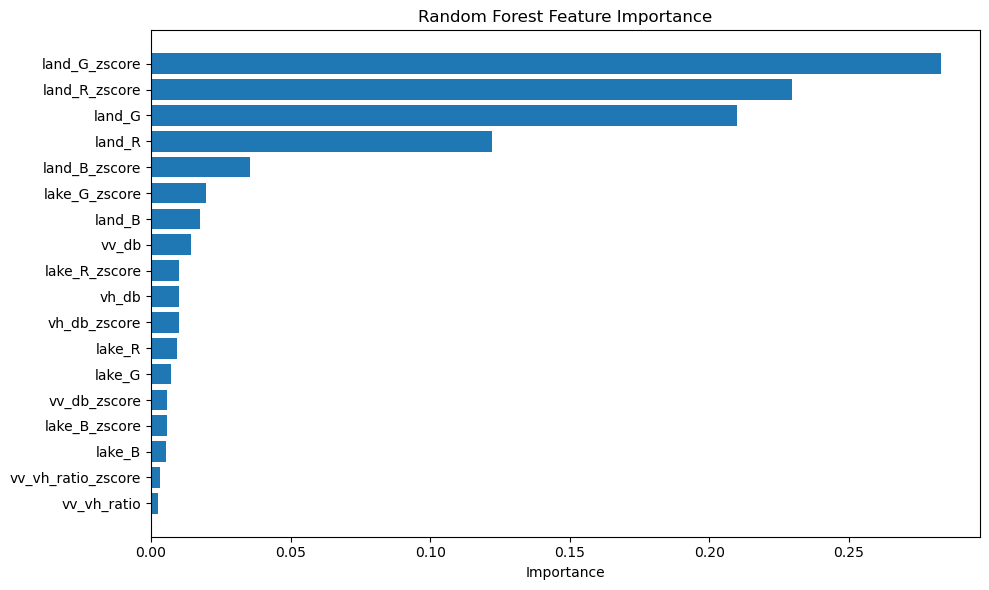


Saved: rf_feature_importance.png


In [47]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols_with_zscore,  # ← Changed from feature_cols
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: rf_feature_importance.png")

---
## Part 7: Apply Classifier to All S1 Data

In [48]:
# First, filter out invalid data
df_s1_clean = df_s1[(df_s1['vv_vh_ratio'] != -999)].copy()  # Remove null VH values
df_s1_clean = df_s1_clean.dropna(subset=feature_cols).copy()

print(f"Cleaned S1 data: {len(df_s1_clean):,} observations (removed {len(df_s1) - len(df_s1_clean):,} with missing data)")

# Add lake-relative z-score features
print("Computing lake-relative z-scores...")

z_score_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']

for col in z_score_cols:
    df_s1_clean[f'{col}_zscore'] = df_s1_clean.groupby('lake_id')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

print(f"Added {len(z_score_cols)} z-score features")

# Update feature columns to include z-scores
feature_cols_with_zscore = feature_cols + [f'{col}_zscore' for col in z_score_cols]

print(f"\nTotal features for classifier: {len(feature_cols_with_zscore)}")
print(f"  Original features: {len(feature_cols)}")
print(f"  Z-score features: {len(z_score_cols)}")

Cleaned S1 data: 15,148 observations (removed 0 with missing data)
Computing lake-relative z-scores...
Added 9 z-score features

Total features for classifier: 18
  Original features: 9
  Z-score features: 9


In [49]:
# Apply Random Forest classifier to all S1 data
print("Applying Random Forest to all S1 observations...")

X_all = df_s1_clean[feature_cols_with_zscore]

# Predict
df_s1_clean['s1_ice_pred'] = rf.predict(X_all)
df_s1_clean['s1_ice_prob'] = rf.predict_proba(X_all)[:, 1]  # Probability of ICE class

print(f"\nPredictions complete!")
print(f"Total observations: {len(df_s1_clean):,}")
print(f"\nPredicted ice distribution:")
print(df_s1_clean['s1_ice_pred'].value_counts())
print(f"\nIce probability stats:")
print(df_s1_clean['s1_ice_prob'].describe())

Applying Random Forest to all S1 observations...

Predictions complete!
Total observations: 15,148

Predicted ice distribution:
s1_ice_pred
1    9136
0    6012
Name: count, dtype: int64

Ice probability stats:
count    15148.000000
mean         0.604644
std          0.433776
min          0.002675
25%          0.062144
50%          0.912895
75%          0.993273
max          0.999820
Name: s1_ice_prob, dtype: float64


---
## Part 8: Create Unified Multi-Sensor Time Series

Combine S2 (high confidence) + S1 (medium confidence) + temperature constraints

In [50]:
# Create unified dataset: ALL S1 dates + ALL S2 dates
print("Creating unified multi-sensor dataset...")

# Prepare S1 data
df_s1_for_unified = df_s1_clean[['lake_id', 'date', 'lake_area_m2', 'centroid_lon', 'centroid_lat',
                                   'temp_c', 's1_ice_pred', 's1_ice_prob']].copy()
df_s1_for_unified['has_s1'] = True

# Prepare S2 data (use deduplicated df_s2)
df_s2_for_unified = df_s2[['lake_id', 'date', 'ice_fraction']].copy()
df_s2_for_unified = df_s2_for_unified.rename(columns={'ice_fraction': 's2_ice_fraction'})
df_s2_for_unified['has_s2'] = True

# Merge on lake_id and date - keep ALL observations from both sensors
df_unified = pd.merge(
    df_s1_for_unified, 
    df_s2_for_unified, 
    on=['lake_id', 'date'], 
    how='outer'  # Keep all S1 dates AND all S2 dates
)

# Fill missing flags
df_unified['has_s1'] = df_unified['has_s1'].fillna(False)
df_unified['has_s2'] = df_unified['has_s2'].fillna(False)

# For S2-only dates, need to add temp and lake metadata
# Merge temperature for all dates
df_unified = df_unified.merge(
    df_era5[['lake_id', 'date', 'temp_c']], 
    on=['lake_id', 'date'], 
    how='left',
    suffixes=('', '_era5')
)
# Use ERA5 temp if S1 temp is missing
df_unified['temp_c'] = df_unified['temp_c'].fillna(df_unified.get('temp_c_era5', pd.Series()))
if 'temp_c_era5' in df_unified.columns:
    df_unified = df_unified.drop(columns=['temp_c_era5'])

# For S2-only dates, get lake metadata from first S1 observation of that lake
lake_metadata = df_s1_for_unified.groupby('lake_id')[['lake_area_m2', 'centroid_lon', 'centroid_lat']].first().reset_index()
df_unified = df_unified.merge(lake_metadata, on='lake_id', how='left', suffixes=('', '_meta'))
for col in ['lake_area_m2', 'centroid_lon', 'centroid_lat']:
    df_unified[col] = df_unified[col].fillna(df_unified.get(f'{col}_meta', pd.Series()))
    if f'{col}_meta' in df_unified.columns:
        df_unified = df_unified.drop(columns=[f'{col}_meta'])

print(f"Unified dataset created:")
print(f"  Total observations: {len(df_unified):,}")
print(f"  S1 only: {(df_unified['has_s1'] & ~df_unified['has_s2']).sum():,}")
print(f"  S2 only: {(df_unified['has_s2'] & ~df_unified['has_s1']).sum():,}")
print(f"  Both S1 and S2: {(df_unified['has_s1'] & df_unified['has_s2']).sum():,}")

Creating unified multi-sensor dataset...
Unified dataset created:
  Total observations: 50,834
  S1 only: 13,466
  S2 only: 35,686
  Both S1 and S2: 1,682


In [51]:
# First, compute 7-day temperature trends for unified dataset
print("Computing 7-day temperature trends for classification...")
df_unified = df_unified.sort_values(['lake_id', 'date'])
df_unified['temp_7day_mean'] = df_unified.groupby('lake_id')['temp_c'].transform(
    lambda x: x.rolling(window=7, min_periods=3, center=False).mean()
)

# Multi-sensor classification with STRICTER temperature constraints
def classify_multisensor(row):
    """
    Classification with temperature TRENDS as constraints.
    
    Uses 7-day rolling mean temperature:
    - 7-day mean > 5°C → Ice very unlikely (sustained above-freezing)
    - 7-day mean < -10°C → Water impossible (sustained hard freeze)
    - Between -10°C and 5°C → Both possible (transition or persistent ice)
    
    Priority:
    1. S2 (if available and physically plausible): HIGH confidence
    2. S1 classifier (if physically plausible): MEDIUM/LOW confidence
    3. Temperature-only: MEDIUM confidence
    """
    s2_decision = None
    s1_decision = None
    
    # Temperature TREND constraints (stricter thresholds)
    temp_trend_available = pd.notna(row.get('temp_7day_mean'))
    
    if temp_trend_available:
        # STRICTER: Sustained above-freezing → ice very unlikely
        # If it's been above freezing for a week in summer, ice should be gone
        temp_too_warm_for_ice = row['temp_7day_mean'] > 5
        # Sustained hard freeze → water impossible
        temp_too_cold_for_water = row['temp_7day_mean'] < -10
    else:
        temp_too_warm_for_ice = False
        temp_too_cold_for_water = False
    
    # ============================================================
    # S2 CLASSIFICATION (with temperature trend override)
    # ============================================================
    if pd.notna(row['s2_ice_fraction']):
        if row['s2_ice_fraction'] > 0.8:
            # S2 says ice
            if temp_too_warm_for_ice:
                # Override: sustained warmth, ice shouldn't exist
                s2_decision = (0, 'MEDIUM', 'S2_TEMP_OVERRIDE')
            else:
                s2_decision = (1, 'HIGH', 'S2')
                
        elif row['s2_ice_fraction'] < 0.2:
            # S2 says water
            if temp_too_cold_for_water:
                # Override: sustained hard freeze, water shouldn't exist
                s2_decision = (1, 'MEDIUM', 'S2_TEMP_OVERRIDE')
            else:
                s2_decision = (0, 'HIGH', 'S2')
                
        else:
            # Partial ice (0.2-0.8) - use temp trend to resolve
            if temp_too_warm_for_ice:
                s2_decision = (0, 'MEDIUM', 'S2_PARTIAL')
            elif temp_too_cold_for_water:
                s2_decision = (1, 'MEDIUM', 'S2_PARTIAL')
            else:
                s2_decision = (0.5, 'MEDIUM', 'S2_PARTIAL')
    
    # ============================================================
    # S1 CLASSIFICATION (with temperature trend override)
    # ============================================================
    if pd.notna(row.get('s1_ice_pred')):
        pred = row['s1_ice_pred']
        source = 'S1'
        
        # Override S1 based on sustained temperature trends
        if pred == 1 and temp_too_warm_for_ice:
            pred = 0
            source = 'S1_TEMP_OVERRIDE'
        elif pred == 0 and temp_too_cold_for_water:
            pred = 1
            source = 'S1_TEMP_OVERRIDE'
        
        # Confidence based on prediction probability
        if row['s1_ice_prob'] > 0.7 or row['s1_ice_prob'] < 0.3:
            conf = 'MEDIUM'
        else:
            conf = 'LOW'
        
        s1_decision = (pred, conf, source)
    
    # ============================================================
    # FINAL DECISION
    # ============================================================
    
    if s2_decision is not None:
        final_decision = s2_decision
    elif s1_decision is not None:
        final_decision = s1_decision
    elif temp_trend_available:
        # Temperature-only decision based on trends
        if temp_too_cold_for_water:
            final_decision = (1, 'MEDIUM', 'TEMP')
        elif temp_too_warm_for_ice:
            final_decision = (0, 'MEDIUM', 'TEMP')
        else:
            final_decision = (np.nan, 'NONE', 'NONE')
    else:
        final_decision = (np.nan, 'NONE', 'NONE')
    
    return pd.Series({
        'ice_binary': final_decision[0],
        'confidence': final_decision[1],
        'source': final_decision[2],
        's1_ice_binary': s1_decision[0] if s1_decision else np.nan,
        's1_confidence': s1_decision[1] if s1_decision else 'NONE',
        's2_ice_binary': s2_decision[0] if s2_decision else np.nan,
        's2_confidence': s2_decision[1] if s2_decision else 'NONE',
    })

print("Classifying with multi-sensor fusion (stricter temperature constraints)...")

# Apply classification function row by row
classification_results = df_unified.apply(classify_multisensor, axis=1)

# CRITICAL: Drop any existing classification columns first to avoid duplicates
cols_to_drop = ['ice_binary', 'confidence', 'source', 's1_ice_binary', 
                's1_confidence', 's2_ice_binary', 's2_confidence']
for col in cols_to_drop:
    if col in df_unified.columns:
        df_unified = df_unified.drop(columns=[col])

# Now add the new classification results
df_unified = df_unified.join(classification_results)

print("\nMulti-sensor classification:")
print(df_unified['source'].value_counts())
print("\nConfidence distribution:")
print(df_unified['confidence'].value_counts())

temp_overrides = df_unified['source'].str.contains('TEMP_OVERRIDE', na=False).sum()
print(f"\nTemperature overrides applied: {temp_overrides}")
print(f"  S2 overridden: {(df_unified['source'] == 'S2_TEMP_OVERRIDE').sum()}")
print(f"  S1 overridden: {(df_unified['source'] == 'S1_TEMP_OVERRIDE').sum()}")

Computing 7-day temperature trends for classification...
Classifying with multi-sensor fusion (stricter temperature constraints)...

Multi-sensor classification:
source
S2                  32776
S1                  13418
S2_PARTIAL           3063
S2_TEMP_OVERRIDE     1431
TEMP                   80
S1_TEMP_OVERRIDE       51
NONE                   15
Name: count, dtype: int64

Confidence distribution:
confidence
HIGH      32776
MEDIUM    17194
LOW         849
NONE         15
Name: count, dtype: int64

Temperature overrides applied: 1482
  S2 overridden: 1431
  S1 overridden: 51


In [52]:
# DIAGNOSTIC: Check classification quality
print("\n" + "="*60)
print("DIAGNOSTIC: Classification Quality Check")
print("="*60)

# Check summer ice detections in final unified dataset
summer_obs = df_unified[df_unified['date'].dt.month.isin([6, 7, 8])].copy()
summer_ice_calls = summer_obs[summer_obs['ice_binary'] == 1].copy()

print(f"\nSummer (Jun-Aug) observations: {len(summer_obs):,}")
print(f"Classified as ICE: {len(summer_ice_calls):,} ({len(summer_ice_calls)/len(summer_obs)*100:.1f}%)")

if len(summer_ice_calls) > 0:
    warm_summer_ice = summer_ice_calls[summer_ice_calls['temp_c'] > 10]
    print(f"  Ice calls with temp > 10°C: {len(warm_summer_ice)} (should be ~0)")
    
    if len(warm_summer_ice) > 0:
        print("\n  WARNING: Found impossible ice classifications:")
        print(warm_summer_ice[['lake_id', 'date', 'ice_binary', 'temp_c', 'source', 'confidence']].head())
    else:
        print("  ✓ All summer ice calls have plausible temperatures")

# Check winter water detections
winter_obs = df_unified[df_unified['date'].dt.month.isin([12, 1, 2])].copy()
winter_water_calls = winter_obs[winter_obs['ice_binary'] == 0].copy()

print(f"\nWinter (Dec-Feb) observations: {len(winter_obs):,}")
print(f"Classified as WATER: {len(winter_water_calls):,} ({len(winter_water_calls)/len(winter_obs)*100:.1f}%)")

if len(winter_water_calls) > 0:
    cold_winter_water = winter_water_calls[winter_water_calls['temp_c'] < -5]
    print(f"  Water calls with temp < -5°C: {len(cold_winter_water)} (should be ~0)")
    
    if len(cold_winter_water) > 0:
        print("\n  WARNING: Found impossible water classifications:")
        print(cold_winter_water[['lake_id', 'date', 'ice_binary', 'temp_c', 'source', 'confidence']].head())
    else:
        print("  ✓ All winter water calls have plausible temperatures")


DIAGNOSTIC: Classification Quality Check

Summer (Jun-Aug) observations: 17,050
Classified as ICE: 992 (5.8%)
  Ice calls with temp > 10°C: 44 (should be ~0)

      lake_id       date  ice_binary     temp_c source confidence
8938   508509 2023-06-06         1.0  10.166776     S2       HIGH
9317   508672 2023-06-06         1.0  10.252877     S2       HIGH
9406   508718 2023-06-06         1.0  10.248808     S2       HIGH
9619   509074 2023-06-06         1.0  10.115914     S2       HIGH
9939   509541 2023-06-06         1.0  10.314970     S2       HIGH

Winter (Dec-Feb) observations: 6,249
Classified as WATER: 21 (0.3%)
  Water calls with temp < -5°C: 12 (should be ~0)

       lake_id       date  ice_binary     temp_c source confidence
1262    500413 2023-01-10         0.0 -26.176243     S1        LOW
1263    500413 2023-01-22         0.0 -20.402353     S1        LOW
3694    503666 2023-12-12         0.0 -20.172018     S1     MEDIUM
16982   517753 2023-01-10         0.0 -26.820774     S1 

In [53]:
# Add temporal features
df_unified['month'] = df_unified['date'].dt.month
df_unified['doy'] = df_unified['date'].dt.dayofyear

# Sort by lake and date
df_unified = df_unified.sort_values(['lake_id', 'date']).reset_index(drop=True)

print(f"\nUnified dataset: {len(df_unified):,} observations")
print(f"Lakes: {df_unified['lake_id'].nunique()}")
print(f"Date range: {df_unified['date'].min()} to {df_unified['date'].max()}")


Unified dataset: 50,834 observations
Lakes: 541
Date range: 2023-01-10 00:00:00 to 2023-12-24 00:00:00


---
## Part 9: Temporal Smoothing and Ice Event Detection

In [54]:
# Temporal smoothing: rolling median per lake
def smooth_timeseries(g):
    g = g.sort_values('date').copy()
    
    # Rolling median (window=3)
    g['ice_smooth'] = (
        g['ice_binary']
        .rolling(window=3, center=True, min_periods=1)
        .median()
        .round()
    )
    
    return g

print("Applying temporal smoothing...")
df_unified = df_unified.groupby('lake_id', group_keys=False).apply(smooth_timeseries)

print("Smoothing complete")

Applying temporal smoothing...
Smoothing complete


In [55]:
# Detect ice-on and ice-off events
def detect_ice_events(g, min_run=2):
    """
    Detect ice-off (spring) and ice-on (fall) dates
    
    Ice-off: First sustained WATER (ice_smooth=0) after April 1 (DOY 91)
    Ice-on: First sustained ICE (ice_smooth=1) after September 1 (DOY 244)
    """
    g = g.sort_values('date').reset_index(drop=True)
    
    # Skip if no valid data
    if g['ice_smooth'].isna().all():
        return pd.Series({
            'ice_off_date': pd.NaT,
            'ice_on_date': pd.NaT,
            'ice_off_doy': np.nan,
            'ice_on_doy': np.nan,
            'ice_free_days': np.nan,
            'ice_off_confidence': 'NONE',
            'ice_on_confidence': 'NONE',
            'ice_off_source': None,
            'ice_on_source': None,
        })
    
    # Ice-off: first sustained water after April 1
    spring = g[g['doy'] >= 91].copy()
    ice_off_date = pd.NaT
    ice_off_conf = 'NONE'
    ice_off_source = None
    
    if not spring.empty:
        water_mask = spring['ice_smooth'] == 0
        count = 0
        for idx in spring.index:
            if water_mask.loc[idx]:
                count += 1
                if count >= min_run:
                    ice_off_idx = idx - count + 1
                    ice_off_date = g.loc[ice_off_idx, 'date']
                    ice_off_conf = g.loc[ice_off_idx, 'confidence']
                    ice_off_source = g.loc[ice_off_idx, 'source']
                    break
            else:
                count = 0
    
    # Ice-on: first sustained ice after September 1
    fall = g[g['doy'] >= 244].copy()
    ice_on_date = pd.NaT
    ice_on_conf = 'NONE'
    ice_on_source = None
    
    if not fall.empty:
        ice_mask = fall['ice_smooth'] == 1
        count = 0
        for idx in fall.index:
            if ice_mask.loc[idx]:
                count += 1
                if count >= min_run:
                    ice_on_idx = idx - count + 1
                    ice_on_date = g.loc[ice_on_idx, 'date']
                    ice_on_conf = g.loc[ice_on_idx, 'confidence']
                    ice_on_source = g.loc[ice_on_idx, 'source']
                    break
            else:
                count = 0
    
    # Compute ice-free days
    if pd.notna(ice_off_date) and pd.notna(ice_on_date):
        ice_free_days = (ice_on_date - ice_off_date).days
    else:
        ice_free_days = np.nan
    
    ice_off_doy = ice_off_date.dayofyear if pd.notna(ice_off_date) else np.nan
    ice_on_doy = ice_on_date.dayofyear if pd.notna(ice_on_date) else np.nan
    
    return pd.Series({
        'ice_off_date': ice_off_date,
        'ice_on_date': ice_on_date,
        'ice_off_doy': ice_off_doy,
        'ice_on_doy': ice_on_doy,
        'ice_free_days': ice_free_days,
        'ice_off_confidence': ice_off_conf,
        'ice_on_confidence': ice_on_conf,
        'ice_off_source': ice_off_source,
        'ice_on_source': ice_on_source,
    })

print("Detecting ice events...")
ice_events = df_unified.groupby('lake_id').apply(detect_ice_events).reset_index()

# Add lake metadata
lake_meta = df_unified.groupby('lake_id').agg({
    'centroid_lat': 'first',
    'centroid_lon': 'first',
    'lake_area_m2': 'first',
}).reset_index()

ice_events = ice_events.merge(lake_meta, on='lake_id')

print("Detection complete!")

Detecting ice events...
Detection complete!


---
## Part 10: Results and Summary Statistics

In [56]:
print("\n" + "="*70)
print("ICE EVENT DETECTION SUMMARY - MULTI-SENSOR APPROACH")
print("="*70)

print(f"\nTotal lakes: {len(ice_events)}")
print(f"Lakes with ice-off detected: {ice_events['ice_off_date'].notna().sum()} ({100*ice_events['ice_off_date'].notna().sum()/len(ice_events):.1f}%)")
print(f"Lakes with ice-on detected: {ice_events['ice_on_date'].notna().sum()} ({100*ice_events['ice_on_date'].notna().sum()/len(ice_events):.1f}%)")
print(f"Lakes with both events: {(ice_events['ice_off_date'].notna() & ice_events['ice_on_date'].notna()).sum()} ({100*(ice_events['ice_off_date'].notna() & ice_events['ice_on_date'].notna()).sum()/len(ice_events):.1f}%)")

print(f"\nIce-off confidence:")
print(ice_events['ice_off_confidence'].value_counts())
print(f"\nIce-off source:")
print(ice_events['ice_off_source'].value_counts())

print(f"\nIce-on confidence:")
print(ice_events['ice_on_confidence'].value_counts())
print(f"\nIce-on source:")
print(ice_events['ice_on_source'].value_counts())


ICE EVENT DETECTION SUMMARY - MULTI-SENSOR APPROACH

Total lakes: 541
Lakes with ice-off detected: 541 (100.0%)
Lakes with ice-on detected: 541 (100.0%)
Lakes with both events: 541 (100.0%)

Ice-off confidence:
ice_off_confidence
HIGH      314
MEDIUM    190
LOW        36
NONE        1
Name: count, dtype: int64

Ice-off source:
ice_off_source
S2                  314
S1                  149
S2_PARTIAL           51
S2_TEMP_OVERRIDE     25
S1_TEMP_OVERRIDE      1
NONE                  1
Name: count, dtype: int64

Ice-on confidence:
ice_on_confidence
HIGH      518
MEDIUM     11
LOW        11
NONE        1
Name: count, dtype: int64

Ice-on source:
ice_on_source
S2            518
S1             19
S2_PARTIAL      3
NONE            1
Name: count, dtype: int64


In [57]:
# Phenology statistics
detected = ice_events[ice_events['ice_off_date'].notna() & ice_events['ice_on_date'].notna()].copy()

if len(detected) > 0:
    print(f"\n{'='*70}")
    print("PHENOLOGY STATISTICS (lakes with both events detected)")
    print(f"{'='*70}")
    print(f"\nN = {len(detected)} lakes")
    
    print(f"\nIce-off (day of year):")
    print(f"  Median: {detected['ice_off_doy'].median():.0f} ({pd.Timestamp('2024-01-01') + pd.Timedelta(days=detected['ice_off_doy'].median()):%b %d})")
    print(f"  Mean:   {detected['ice_off_doy'].mean():.0f}")
    print(f"  Std:    {detected['ice_off_doy'].std():.0f} days")
    print(f"  Range:  {detected['ice_off_doy'].min():.0f} - {detected['ice_off_doy'].max():.0f}")
    print(f"  IQR:    {detected['ice_off_doy'].quantile(0.25):.0f} - {detected['ice_off_doy'].quantile(0.75):.0f}")
    
    print(f"\nIce-on (day of year):")
    print(f"  Median: {detected['ice_on_doy'].median():.0f} ({pd.Timestamp('2024-01-01') + pd.Timedelta(days=detected['ice_on_doy'].median()):%b %d})")
    print(f"  Mean:   {detected['ice_on_doy'].mean():.0f}")
    print(f"  Std:    {detected['ice_on_doy'].std():.0f} days")
    print(f"  Range:  {detected['ice_on_doy'].min():.0f} - {detected['ice_on_doy'].max():.0f}")
    print(f"  IQR:    {detected['ice_on_doy'].quantile(0.25):.0f} - {detected['ice_on_doy'].quantile(0.75):.0f}")
    
    print(f"\nIce-free season (days):")
    print(f"  Median: {detected['ice_free_days'].median():.0f}")
    print(f"  Mean:   {detected['ice_free_days'].mean():.0f}")
    print(f"  Std:    {detected['ice_free_days'].std():.0f} days")
    print(f"  Range:  {detected['ice_free_days'].min():.0f} - {detected['ice_free_days'].max():.0f}")
    print(f"  IQR:    {detected['ice_free_days'].quantile(0.25):.0f} - {detected['ice_free_days'].quantile(0.75):.0f}")


PHENOLOGY STATISTICS (lakes with both events detected)

N = 541 lakes

Ice-off (day of year):
  Median: 154 (Jun 03)
  Mean:   154
  Std:    7 days
  Range:  139 - 174
  IQR:    146 - 158

Ice-on (day of year):
  Median: 278 (Oct 05)
  Mean:   277
  Std:    4 days
  Range:  250 - 286
  IQR:    276 - 278

Ice-free season (days):
  Median: 123
  Mean:   124
  Std:    8 days
  Range:  97 - 144
  IQR:    119 - 130


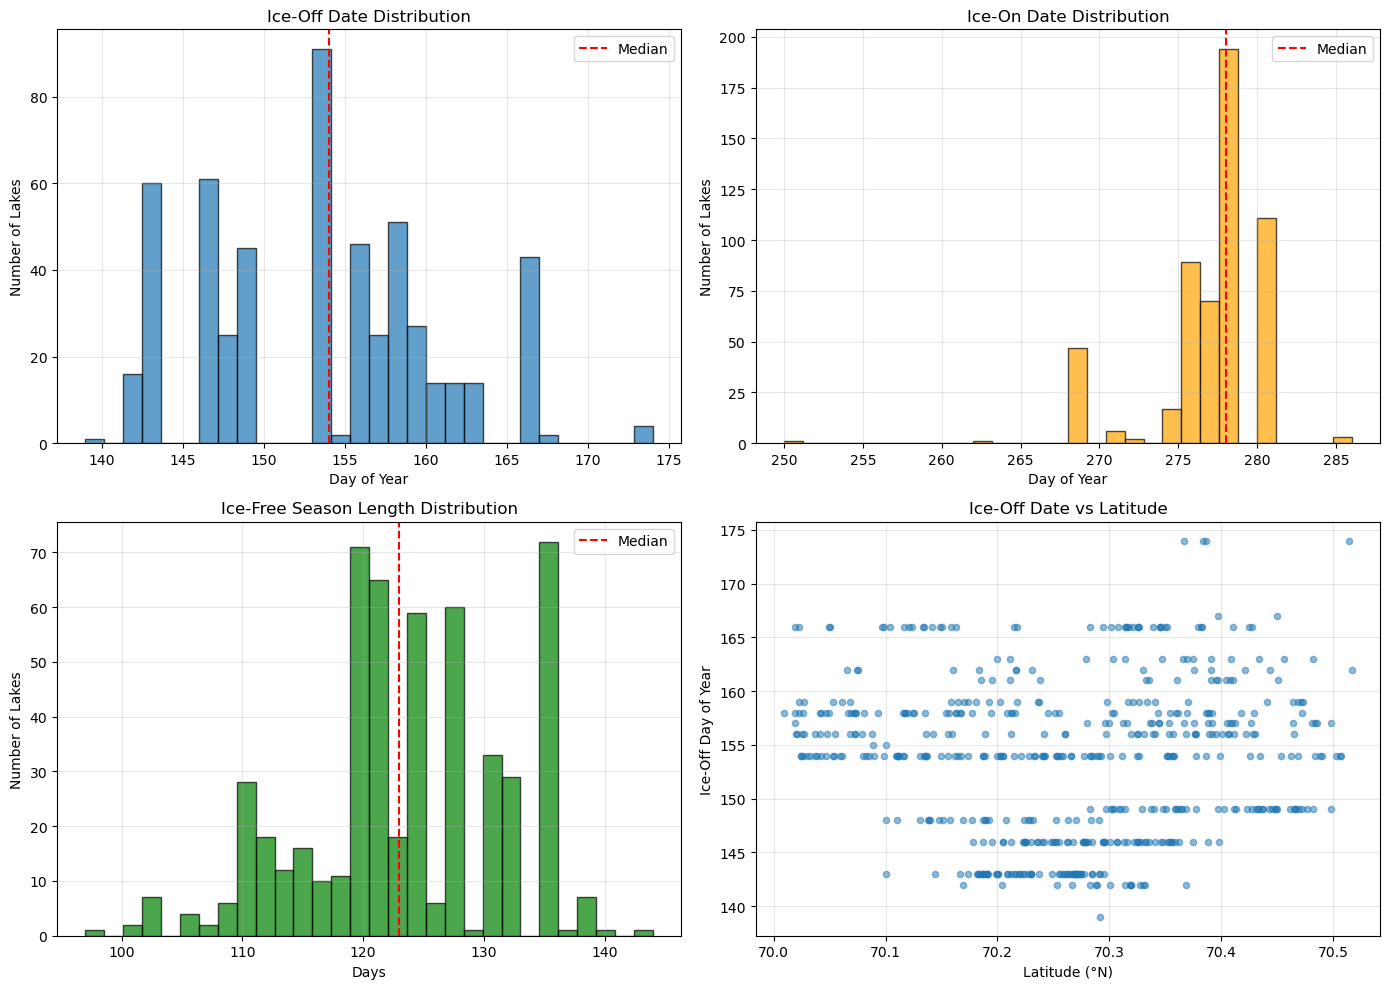


Saved: ice_phenology_summary.png


In [58]:
# Visualizations
if len(detected) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Ice-off histogram
    axes[0, 0].hist(detected['ice_off_doy'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(detected['ice_off_doy'].median(), color='red', linestyle='--', label='Median')
    axes[0, 0].set_xlabel('Day of Year')
    axes[0, 0].set_ylabel('Number of Lakes')
    axes[0, 0].set_title('Ice-Off Date Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Ice-on histogram
    axes[0, 1].hist(detected['ice_on_doy'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].axvline(detected['ice_on_doy'].median(), color='red', linestyle='--', label='Median')
    axes[0, 1].set_xlabel('Day of Year')
    axes[0, 1].set_ylabel('Number of Lakes')
    axes[0, 1].set_title('Ice-On Date Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Ice-free days histogram
    axes[1, 0].hist(detected['ice_free_days'], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[1, 0].axvline(detected['ice_free_days'].median(), color='red', linestyle='--', label='Median')
    axes[1, 0].set_xlabel('Days')
    axes[1, 0].set_ylabel('Number of Lakes')
    axes[1, 0].set_title('Ice-Free Season Length Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Ice-off vs latitude
    axes[1, 1].scatter(detected['centroid_lat'], detected['ice_off_doy'], alpha=0.5, s=20)
    axes[1, 1].set_xlabel('Latitude (°N)')
    axes[1, 1].set_ylabel('Ice-Off Day of Year')
    axes[1, 1].set_title('Ice-Off Date vs Latitude')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ice_phenology_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nSaved: ice_phenology_summary.png")

---
## Part 11: Save Results

In [59]:
# Save ice events
ice_events.to_csv('alaska_lakes_ice_events_multisensor_2024.csv', index=False)
print("Saved: alaska_lakes_ice_events_multisensor_2024.csv")

# Save full time series
df_unified.to_csv('alaska_lakes_timeseries_multisensor_2024.csv', index=False)
print("Saved: alaska_lakes_timeseries_multisensor_2024.csv")

print("\nAll results saved!")

Saved: alaska_lakes_ice_events_multisensor_2024.csv
Saved: alaska_lakes_timeseries_multisensor_2024.csv

All results saved!


---
## Part 12: Example Time Series Plots

Visualize multi-sensor data for a few example lakes

Big lakes (>75th percentile): 135 lakes, area > 0.03 km²
Small lakes (<25th percentile): 135 lakes, area < 0.00 km²

Selected lakes:
  Lake 632270: 26185.348 m²
  Lake 627422: 124399.042 m²
  Lake 516861: 1254.823 m²
  Lake 647034: 1272.651 m²


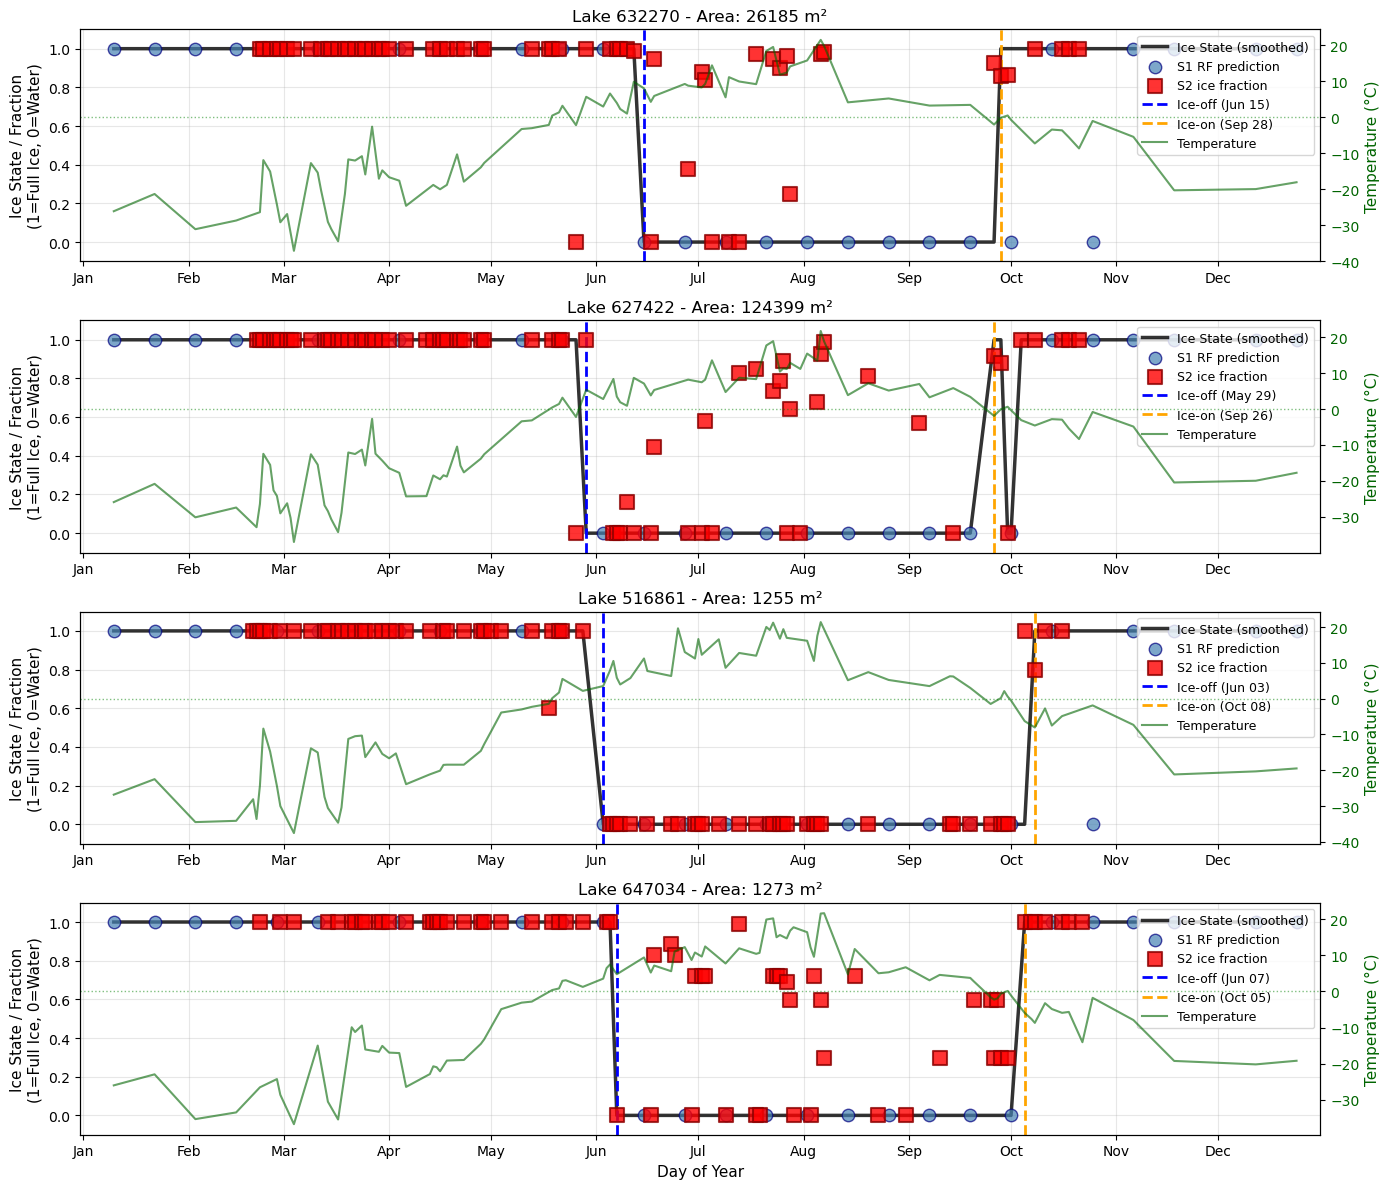


Saved: example_lake_timeseries.png


In [60]:
# Pick lakes strategically: 2 big, 2 small
detected_valid = ice_events[ice_events['ice_off_date'].notna() & 
                            ice_events['ice_on_date'].notna()].copy()

# Define big vs small by quartiles (not median)
q75 = detected_valid['lake_area_m2'].quantile(0.75)
q25 = detected_valid['lake_area_m2'].quantile(0.25)

big_lakes = detected_valid[detected_valid['lake_area_m2'] > q75]
small_lakes = detected_valid[detected_valid['lake_area_m2'] < q25]

print(f"Big lakes (>75th percentile): {len(big_lakes)} lakes, area > {q75/1e6:.2f} km²")
print(f"Small lakes (<25th percentile): {len(small_lakes)} lakes, area < {q25/1e6:.2f} km²")

# Sample 2 from each
np.random.seed(42)
example_lakes = np.concatenate([
    big_lakes.sample(2)['lake_id'].values,
    small_lakes.sample(2)['lake_id'].values
])

print(f"\nSelected lakes:")
for lake_id in example_lakes:
    lake_info = ice_events[ice_events['lake_id'] == lake_id].iloc[0]
    print(f"  Lake {lake_id}: {lake_info['lake_area_m2']:.3f} m²")

fig, axes = plt.subplots(len(example_lakes), 1, figsize=(14, 3*len(example_lakes)))

for i, lake_id in enumerate(example_lakes):
    lake_data = df_unified[df_unified['lake_id'] == lake_id].copy()
    lake_events_row = ice_events[ice_events['lake_id'] == lake_id].iloc[0]
    
    ax = axes[i] if len(example_lakes) > 1 else axes
    
    # Plot smoothed ice state (multi-sensor fusion result)
    ax.plot(lake_data['doy'], lake_data['ice_smooth'], '-', markersize=0, 
            label='Ice State (smoothed)', alpha=0.8, color='black', linewidth=2.5)
    
    # Plot S1 RF predictions - ALWAYS show when S1 data exists
    s1_data = lake_data[lake_data['has_s1'] == True]
    ax.scatter(s1_data['doy'], s1_data['s1_ice_binary'], s=80, marker='o', 
               color='steelblue', alpha=0.7, label='S1 RF prediction', zorder=4, 
               edgecolors='navy', linewidths=1)
    
    # Plot S2 ice fraction - ALWAYS show when S2 data exists
    s2_data = lake_data[lake_data['has_s2'] == True]
    ax.scatter(s2_data['doy'], s2_data['s2_ice_fraction'], s=100, marker='s', 
               color='red', alpha=0.8, label='S2 ice fraction', zorder=5, 
               edgecolors='darkred', linewidths=1.5)
    
    # Mark ice-off and ice-on
    if pd.notna(lake_events_row['ice_off_date']):
        ice_off_doy = pd.to_datetime(lake_events_row['ice_off_date']).dayofyear
        ax.axvline(ice_off_doy, color='blue', linestyle='--', 
                   linewidth=2, label=f"Ice-off ({lake_events_row['ice_off_date']:%b %d})")
    if pd.notna(lake_events_row['ice_on_date']):
        ice_on_doy = pd.to_datetime(lake_events_row['ice_on_date']).dayofyear
        ax.axvline(ice_on_doy, color='orange', linestyle='--', 
                   linewidth=2, label=f"Ice-on ({lake_events_row['ice_on_date']:%b %d})")
    
    ax.set_ylabel('Ice State / Fraction\n(1=Full Ice, 0=Water)', fontsize=11)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 365)
    
    # Add month labels on x-axis
    month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_labels)
    
    # Create second y-axis for temperature
    ax2 = ax.twinx()
    ax2.plot(lake_data['doy'], lake_data['temp_c'], color='darkgreen', 
             linewidth=1.5, alpha=0.6, label='Temperature')
    ax2.axhline(0, color='green', linestyle=':', linewidth=1, alpha=0.5)
    ax2.set_ylabel('Temperature (°C)', color='darkgreen', fontsize=11)
    ax2.tick_params(axis='y', labelcolor='darkgreen')
    
    # Title
    ax.set_title(f"Lake {lake_id} - Area: {lake_events_row['lake_area_m2']:.0f} m²", 
                 fontsize=12)
    
    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)
    
    ax.grid(alpha=0.3)
    
    if i == len(example_lakes) - 1:
        ax.set_xlabel('Day of Year', fontsize=11)

plt.tight_layout()
plt.savefig('example_lake_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: example_lake_timeseries.png")

## Part 13: Lake Geometry vs Ice Phenology 

In [64]:
print("="*60)
print("PART 13: LAKE GEOMETRY vs ICE PHENOLOGY ANALYSIS")
print("="*60)

# First, we need to get the geometry metrics from the original export
# They should be in the lake metadata columns
print("\nChecking available geometry metrics...")
geom_cols = [col for col in ice_events.columns if any(x in col.lower() for x in 
             ['area', 'perim', 'circular', 'convex', 'fractal', 'fetch', 'elongation'])]
print(f"Found geometry columns: {geom_cols}")

# If geometry metrics aren't in ice_events, merge from df_unified
if 'circularity' not in ice_events.columns:
    print("\nMerging geometry metrics from unified dataset...")
    geom_metrics = df_unified.groupby('lake_id').agg({
        'lake_area_m2': 'first',
        'centroid_lon': 'first',
        'centroid_lat': 'first'
    }).reset_index()
    
    # Note: circularity, convexity, etc. were computed in GEE but need to be in the export
    # For now, we can compute some metrics from area
    ice_events_with_geom = ice_events.copy()
else:
    ice_events_with_geom = ice_events.copy()

# Convert area to km²
ice_events_with_geom['lake_area_km2'] = ice_events_with_geom['lake_area_m2'] / 1e6

# Only analyze lakes with both ice-on and ice-off detected
valid_events = ice_events_with_geom[
    ice_events_with_geom['ice_off_date'].notna() & 
    ice_events_with_geom['ice_on_date'].notna()
].copy()

print(f"\nLakes with valid ice events: {len(valid_events)}")
print(f"  Mean area: {valid_events['lake_area_km2'].mean():.3f} km²")
print(f"  Median area: {valid_events['lake_area_km2'].median():.3f} km²")
print(f"  Min area: {valid_events['lake_area_km2'].min():.4f} km²")
print(f"  Max area: {valid_events['lake_area_km2'].max():.3f} km²")

PART 13: LAKE GEOMETRY vs ICE PHENOLOGY ANALYSIS

Checking available geometry metrics...
Found geometry columns: ['lake_area_m2']

Merging geometry metrics from unified dataset...

Lakes with valid ice events: 541
  Mean area: 0.054 km²
  Median area: 0.006 km²
  Min area: 0.0012 km²
  Max area: 0.775 km²


In [74]:
print("\n" + "="*60)
print("EXTRACTING GEOMETRY METRICS FROM GEE")
print("="*60)

# The lakes_with_geom FeatureCollection in GEE has all the geometry metrics
# We just need to extract them to a Python DataFrame

print("Fetching geometry metrics from GEE FeatureCollection...")

# Get the properties we want
geom_properties = ['lake_id', 'lake_area_m2', 'lake_perim_m', 'circularity', 
                   'fractal_dim', 'convexity', 'centroid_lon', 'centroid_lat']

# Note: 'lake_id' field name from your config
lake_id_field = LAKE_ID_FIELD  # Should be 'id' from your config

# Create a simple feature collection with just the properties we need
def extract_props(feat):
    return ee.Feature(None, {
        'lake_id': feat.get(lake_id_field),
        'lake_area_m2': feat.get('lake_area_m2'),
        'lake_perim_m': feat.get('lake_perim_m'),
        'circularity': feat.get('circularity'),
        'fractal_dim': feat.get('fractal_dim'),
        'convexity': feat.get('convexity'),
        'centroid_lon': feat.get('centroid_lon'),
        'centroid_lat': feat.get('centroid_lat')
    })

geom_fc = lakes_with_geom.map(extract_props)

# Convert to DataFrame (this will take a moment as it fetches from GEE)
print("Converting to DataFrame (this may take 30-60 seconds)...")
geom_list = geom_fc.getInfo()['features']
geom_data = pd.DataFrame([feat['properties'] for feat in geom_list])

print(f"Fetched geometry metrics for {len(geom_data)} lakes")
print(f"\nColumns: {geom_data.columns.tolist()}")
print(f"\nFirst few rows:")
print(geom_data.head())

# Merge with ice_events
print("\nMerging geometry metrics with ice phenology data...")
ice_events_with_geom = ice_events.merge(geom_data, on='lake_id', how='left', suffixes=('', '_geom'))

# Clean up duplicate columns if any
for col in ['lake_area_m2', 'centroid_lon', 'centroid_lat']:
    if f'{col}_geom' in ice_events_with_geom.columns:
        # Use the GEE version (more accurate)
        ice_events_with_geom[col] = ice_events_with_geom[f'{col}_geom'].fillna(ice_events_with_geom[col])
        ice_events_with_geom = ice_events_with_geom.drop(columns=[f'{col}_geom'])

# Add area in km2
ice_events_with_geom['lake_area_km2'] = ice_events_with_geom['lake_area_m2'] / 1e6

print(f"\nMerged! Now have {len(ice_events_with_geom.columns)} columns")
print(f"\nNew geometry columns:")
for col in ['circularity', 'fractal_dim', 'convexity', 'lake_perim_m']:
    if col in ice_events_with_geom.columns:
        print(f"  {col}: {ice_events_with_geom[col].notna().sum()} valid values")

# Update valid_events
valid_events = ice_events_with_geom[
    ice_events_with_geom['ice_off_date'].notna() & 
    ice_events_with_geom['ice_on_date'].notna()
].copy()

print(f"\nValid events updated: {len(valid_events)} lakes with complete data")

httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.



EXTRACTING GEOMETRY METRICS FROM GEE
Fetching geometry metrics from GEE FeatureCollection...
Converting to DataFrame (this may take 30-60 seconds)...
Fetched geometry metrics for 541 lakes

Columns: ['centroid_lat', 'centroid_lon', 'circularity', 'convexity', 'fractal_dim', 'lake_area_m2', 'lake_id', 'lake_perim_m']

First few rows:
   centroid_lat  centroid_lon  circularity  convexity  fractal_dim  \
0     70.506790   -149.448756     0.500589   0.885012     1.062886   
1     70.136282   -150.255465     0.270078   0.685783     1.124792   
2     70.019442   -151.098083     0.556275   0.853914     1.047711   
3     70.429362   -149.007892     0.383864   0.723140     1.098775   
4     70.417517   -148.997664     0.282162   0.649969     1.145016   

   lake_area_m2  lake_id  lake_perim_m  
0   1289.839988   626180    179.941941  
1   5187.720510   513659    491.301770  
2   1379.680723   517753    176.542654  
3   1405.058196   627738    214.468448  
4   1163.592946   628049    227.643891

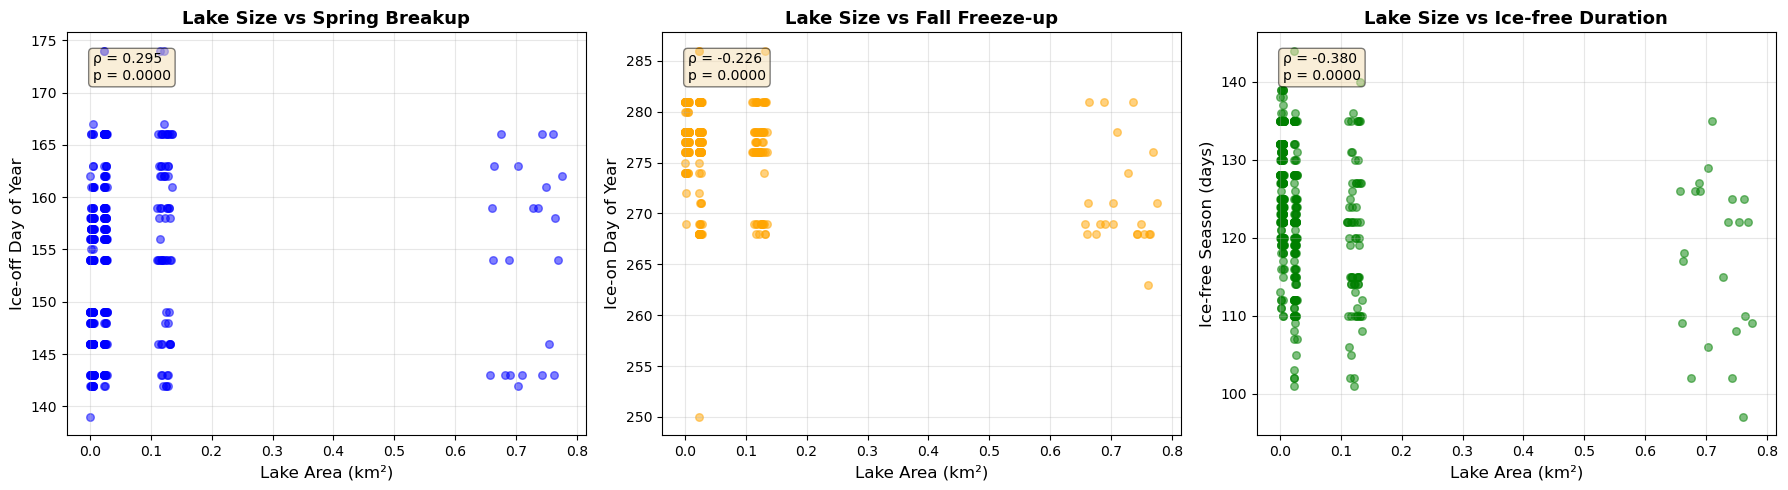


Saved: lake_size_vs_ice_phenology.png

Key findings:
  Ice-off vs area: ρ=0.295 (p=0.0000)
  Ice-on vs area: ρ=-0.226 (p=0.0000)
  Ice-free days vs area: ρ=-0.380 (p=0.0000)


In [75]:
# Analyze relationship between lake size and ice phenology
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Lake area vs Ice-off date
ax = axes[0]
ax.scatter(valid_events['lake_area_km2'], valid_events['ice_off_doy'], 
           alpha=0.5, s=30, color='blue')
ax.set_xlabel('Lake Area (km²)', fontsize=12)
ax.set_ylabel('Ice-off Day of Year', fontsize=12)
ax.set_title('Lake Size vs Spring Breakup', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# Add correlation
from scipy.stats import spearmanr
corr_off, p_off = spearmanr(valid_events['lake_area_km2'], valid_events['ice_off_doy'])
ax.text(0.05, 0.95, f'ρ = {corr_off:.3f}\np = {p_off:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Lake area vs Ice-on date
ax = axes[1]
ax.scatter(valid_events['lake_area_km2'], valid_events['ice_on_doy'], 
           alpha=0.5, s=30, color='orange')
ax.set_xlabel('Lake Area (km²)', fontsize=12)
ax.set_ylabel('Ice-on Day of Year', fontsize=12)
ax.set_title('Lake Size vs Fall Freeze-up', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

corr_on, p_on = spearmanr(valid_events['lake_area_km2'], valid_events['ice_on_doy'])
ax.text(0.05, 0.95, f'ρ = {corr_on:.3f}\np = {p_on:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Lake area vs Ice-free season
ax = axes[2]
ax.scatter(valid_events['lake_area_km2'], valid_events['ice_free_days'], 
           alpha=0.5, s=30, color='green')
ax.set_xlabel('Lake Area (km²)', fontsize=12)
ax.set_ylabel('Ice-free Season (days)', fontsize=12)
ax.set_title('Lake Size vs Ice-free Duration', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

corr_season, p_season = spearmanr(valid_events['lake_area_km2'], valid_events['ice_free_days'])
ax.text(0.05, 0.95, f'ρ = {corr_season:.3f}\np = {p_season:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('lake_size_vs_ice_phenology.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: lake_size_vs_ice_phenology.png")
print("\nKey findings:")
print(f"  Ice-off vs area: ρ={corr_off:.3f} (p={p_off:.4f})")
print(f"  Ice-on vs area: ρ={corr_on:.3f} (p={p_on:.4f})")
print(f"  Ice-free days vs area: ρ={corr_season:.3f} (p={p_season:.4f})")


ICE PHENOLOGY BY LAKE SIZE CLASS

Very Small (<0.05) km² (n=450):
  Ice-off: 153.0 ± 6.8 DOY
  Ice-on:  277.5 ± 3.1 DOY
  Ice-free: 124.5 ± 7.6 days

Small (0.05-0.1) km² (n=0):
  Ice-off: nan ± nan DOY
  Ice-on:  nan ± nan DOY
  Ice-free: nan ± nan days

Medium (0.1-0.5) km² (n=69):
  Ice-off: 156.5 ± 8.5 DOY
  Ice-on:  276.0 ± 4.4 DOY
  Ice-free: 119.5 ± 9.3 days

Large (>0.5) km² (n=22):
  Ice-off: 154.1 ± 9.1 DOY
  Ice-on:  271.3 ± 5.0 DOY
  Ice-free: 117.2 ± 10.3 days


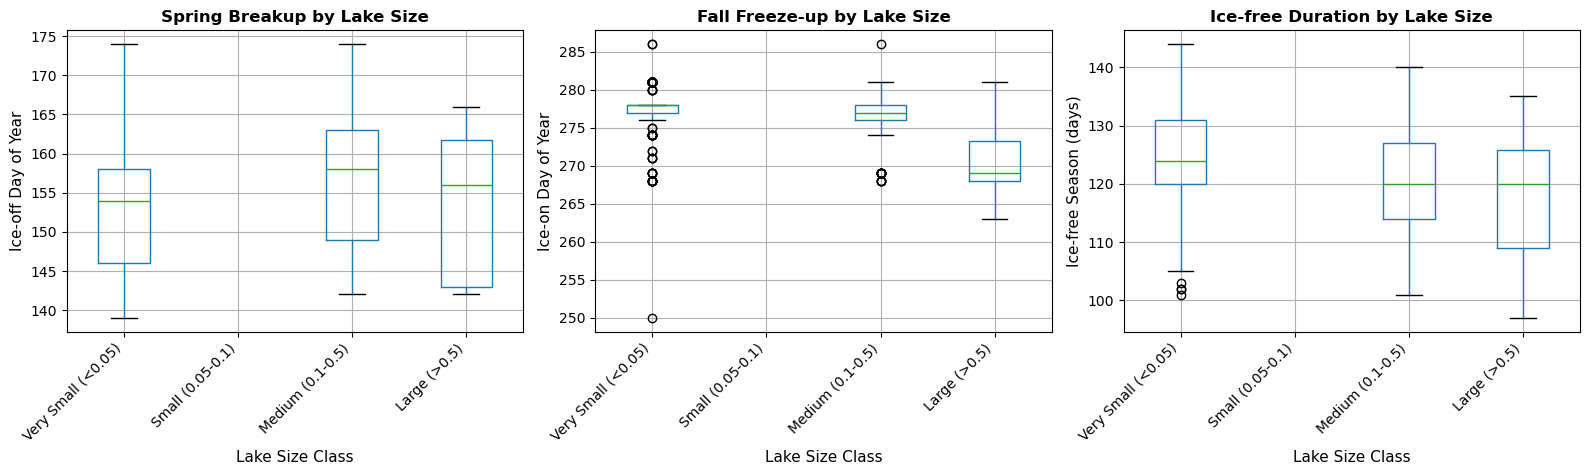


Saved: ice_phenology_by_size_class.png


In [76]:
# Categorize lakes by size
valid_events['size_class'] = pd.cut(
    valid_events['lake_area_km2'], 
    bins=[0, 0.05, 0.1, 0.5, 10],
    labels=['Very Small (<0.05)', 'Small (0.05-0.1)', 'Medium (0.1-0.5)', 'Large (>0.5)']
)

# Summary statistics by size class
print("\n" + "="*60)
print("ICE PHENOLOGY BY LAKE SIZE CLASS")
print("="*60)

for size_class in valid_events['size_class'].cat.categories:
    subset = valid_events[valid_events['size_class'] == size_class]
    print(f"\n{size_class} km² (n={len(subset)}):")
    print(f"  Ice-off: {subset['ice_off_doy'].mean():.1f} ± {subset['ice_off_doy'].std():.1f} DOY")
    print(f"  Ice-on:  {subset['ice_on_doy'].mean():.1f} ± {subset['ice_on_doy'].std():.1f} DOY")
    print(f"  Ice-free: {subset['ice_free_days'].mean():.1f} ± {subset['ice_free_days'].std():.1f} days")

# Boxplots by size class
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Ice-off
ax = axes[0]
valid_events.boxplot(column='ice_off_doy', by='size_class', ax=ax)
ax.set_xlabel('Lake Size Class', fontsize=11)
ax.set_ylabel('Ice-off Day of Year', fontsize=11)
ax.set_title('Spring Breakup by Lake Size', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax.get_figure().suptitle('')  # Remove default title

# Ice-on
ax = axes[1]
valid_events.boxplot(column='ice_on_doy', by='size_class', ax=ax)
ax.set_xlabel('Lake Size Class', fontsize=11)
ax.set_ylabel('Ice-on Day of Year', fontsize=11)
ax.set_title('Fall Freeze-up by Lake Size', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax.get_figure().suptitle('')

# Ice-free days
ax = axes[2]
valid_events.boxplot(column='ice_free_days', by='size_class', ax=ax)
ax.set_xlabel('Lake Size Class', fontsize=11)
ax.set_ylabel('Ice-free Season (days)', fontsize=11)
ax.set_title('Ice-free Duration by Lake Size', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax.get_figure().suptitle('')

plt.tight_layout()
plt.savefig('ice_phenology_by_size_class.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: ice_phenology_by_size_class.png")

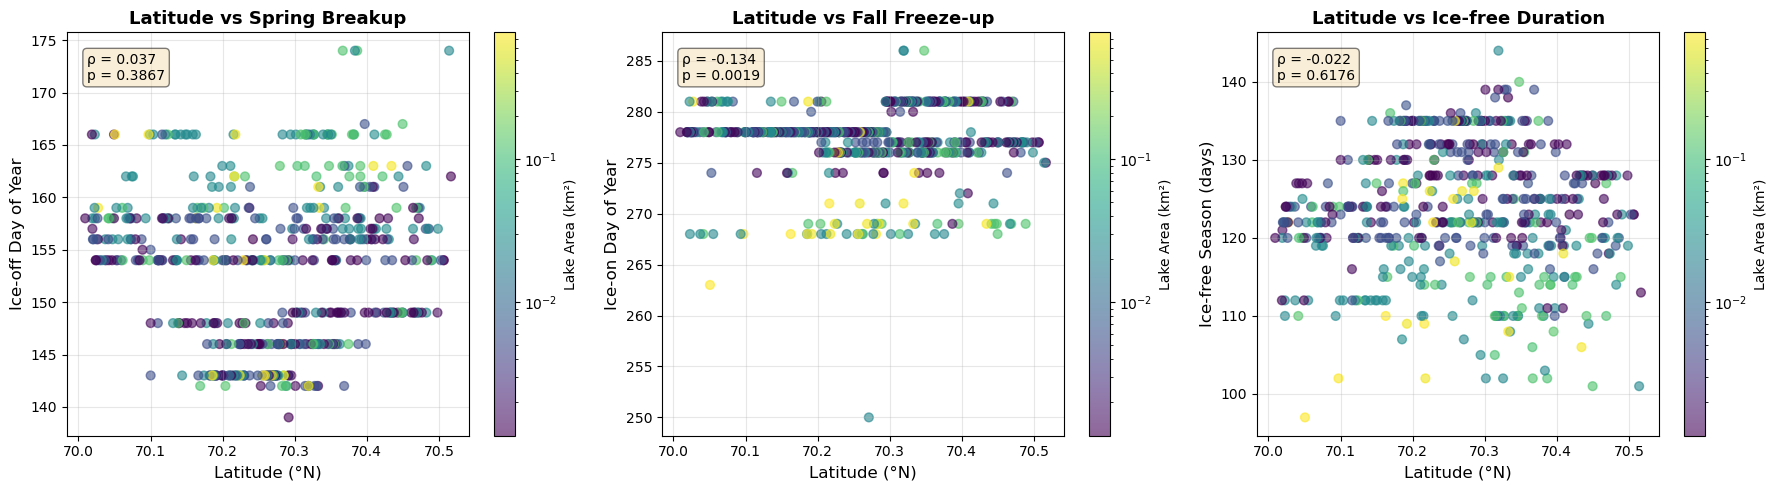


Saved: latitude_vs_ice_phenology.png

Latitudinal gradients:
  Ice-off vs latitude: ρ=0.037 (p=0.3867)
  Ice-on vs latitude: ρ=-0.134 (p=0.0019)
  Ice-free days vs latitude: ρ=-0.022 (p=0.6176)


In [77]:
# Analyze latitude gradient
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Latitude vs Ice-off
ax = axes[0]
scatter = ax.scatter(valid_events['centroid_lat'], valid_events['ice_off_doy'],
                     c=valid_events['lake_area_km2'], cmap='viridis', 
                     alpha=0.6, s=40, norm=plt.matplotlib.colors.LogNorm())
ax.set_xlabel('Latitude (°N)', fontsize=12)
ax.set_ylabel('Ice-off Day of Year', fontsize=12)
ax.set_title('Latitude vs Spring Breakup', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lake Area (km²)', fontsize=10)

corr_lat_off, p_lat_off = spearmanr(valid_events['centroid_lat'], valid_events['ice_off_doy'])
ax.text(0.05, 0.95, f'ρ = {corr_lat_off:.3f}\np = {p_lat_off:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Latitude vs Ice-on
ax = axes[1]
scatter = ax.scatter(valid_events['centroid_lat'], valid_events['ice_on_doy'],
                     c=valid_events['lake_area_km2'], cmap='viridis',
                     alpha=0.6, s=40, norm=plt.matplotlib.colors.LogNorm())
ax.set_xlabel('Latitude (°N)', fontsize=12)
ax.set_ylabel('Ice-on Day of Year', fontsize=12)
ax.set_title('Latitude vs Fall Freeze-up', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lake Area (km²)', fontsize=10)

corr_lat_on, p_lat_on = spearmanr(valid_events['centroid_lat'], valid_events['ice_on_doy'])
ax.text(0.05, 0.95, f'ρ = {corr_lat_on:.3f}\np = {p_lat_on:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Latitude vs Ice-free season
ax = axes[2]
scatter = ax.scatter(valid_events['centroid_lat'], valid_events['ice_free_days'],
                     c=valid_events['lake_area_km2'], cmap='viridis',
                     alpha=0.6, s=40, norm=plt.matplotlib.colors.LogNorm())
ax.set_xlabel('Latitude (°N)', fontsize=12)
ax.set_ylabel('Ice-free Season (days)', fontsize=12)
ax.set_title('Latitude vs Ice-free Duration', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lake Area (km²)', fontsize=10)

corr_lat_season, p_lat_season = spearmanr(valid_events['centroid_lat'], valid_events['ice_free_days'])
ax.text(0.05, 0.95, f'ρ = {corr_lat_season:.3f}\np = {p_lat_season:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('latitude_vs_ice_phenology.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: latitude_vs_ice_phenology.png")
print("\nLatitudinal gradients:")
print(f"  Ice-off vs latitude: ρ={corr_lat_off:.3f} (p={p_lat_off:.4f})")
print(f"  Ice-on vs latitude: ρ={corr_lat_on:.3f} (p={p_lat_on:.4f})")
print(f"  Ice-free days vs latitude: ρ={corr_lat_season:.3f} (p={p_lat_season:.4f})")


DETECTION CONFIDENCE vs LAKE CHARACTERISTICS

% High-confidence detections by lake size:
                    ice_off_confidence  ice_on_confidence  n_lakes
size_class                                                        
Very Small (<0.05)           62.222222          95.555556      450
Small (0.05-0.1)                   NaN                NaN        0
Medium (0.1-0.5)             40.579710          97.101449       69
Large (>0.5)                 27.272727          95.454545       22


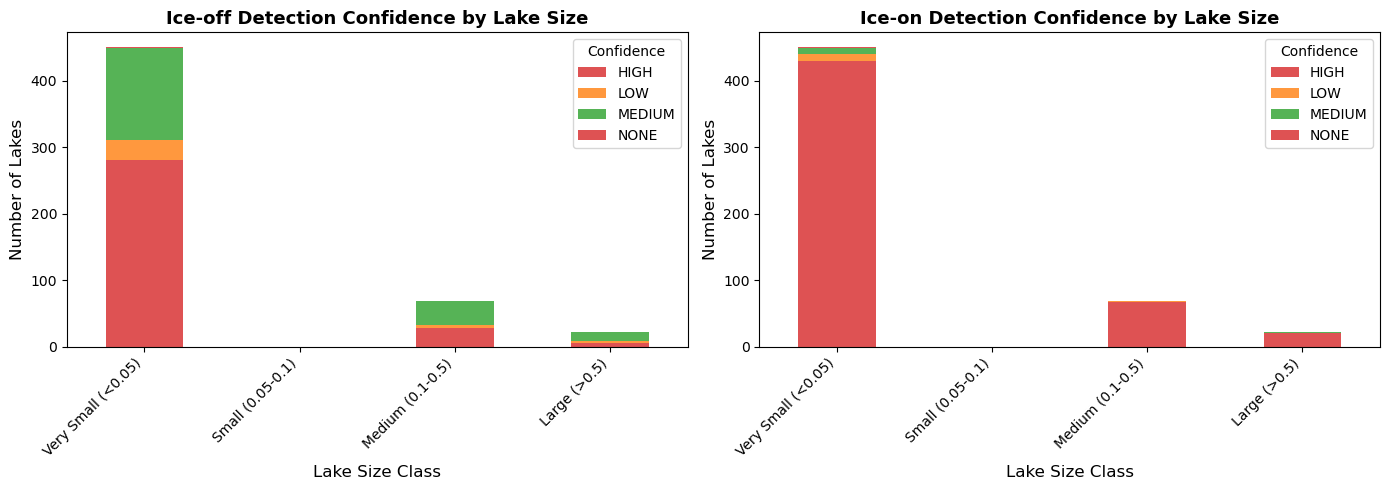


Saved: detection_confidence_by_size.png


In [78]:
# Analyze if detection confidence varies with lake characteristics
print("\n" + "="*60)
print("DETECTION CONFIDENCE vs LAKE CHARACTERISTICS")
print("="*60)

# Add size_class to ice_events_with_geom
ice_events_conf = ice_events_with_geom.copy()
ice_events_conf['size_class'] = pd.cut(
    ice_events_conf['lake_area_km2'], 
    bins=[0, 0.05, 0.1, 0.5, 10],
    labels=['Very Small (<0.05)', 'Small (0.05-0.1)', 'Medium (0.1-0.5)', 'Large (>0.5)']
)

# Filter to lakes with detections
ice_events_conf = ice_events_conf[
    ice_events_conf['ice_off_date'].notna() & 
    ice_events_conf['ice_on_date'].notna()
].copy()

# Confidence by size class
conf_by_size = ice_events_conf.groupby('size_class').agg({
    'ice_off_confidence': lambda x: (x == 'HIGH').sum() / len(x) * 100,
    'ice_on_confidence': lambda x: (x == 'HIGH').sum() / len(x) * 100,
    'lake_id': 'count'
}).rename(columns={'lake_id': 'n_lakes'})

print("\n% High-confidence detections by lake size:")
print(conf_by_size)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ice-off confidence
ax = axes[0]
conf_counts_off = ice_events_conf.groupby(['size_class', 'ice_off_confidence']).size().unstack(fill_value=0)
conf_counts_off.plot(kind='bar', stacked=True, ax=ax, 
                     color=['#d62728', '#ff7f0e', '#2ca02c'],
                     alpha=0.8)
ax.set_xlabel('Lake Size Class', fontsize=12)
ax.set_ylabel('Number of Lakes', fontsize=12)
ax.set_title('Ice-off Detection Confidence by Lake Size', fontsize=13, fontweight='bold')
ax.legend(title='Confidence', loc='upper right')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ice-on confidence
ax = axes[1]
conf_counts_on = ice_events_conf.groupby(['size_class', 'ice_on_confidence']).size().unstack(fill_value=0)
conf_counts_on.plot(kind='bar', stacked=True, ax=ax,
                    color=['#d62728', '#ff7f0e', '#2ca02c'],
                    alpha=0.8)
ax.set_xlabel('Lake Size Class', fontsize=12)
ax.set_ylabel('Number of Lakes', fontsize=12)
ax.set_title('Ice-on Detection Confidence by Lake Size', fontsize=13, fontweight='bold')
ax.legend(title='Confidence', loc='upper right')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('detection_confidence_by_size.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: detection_confidence_by_size.png")

In [79]:
# Create comprehensive summary table
print("\n" + "="*60)
print("COMPREHENSIVE ICE PHENOLOGY SUMMARY")
print("="*60)

summary = valid_events.groupby('size_class').agg({
    'lake_id': 'count',
    'ice_off_doy': ['mean', 'std', 'min', 'max'],
    'ice_on_doy': ['mean', 'std', 'min', 'max'],
    'ice_free_days': ['mean', 'std', 'min', 'max']
})

summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.rename(columns={'lake_id_count': 'n_lakes'})

print("\nIce Phenology Summary by Lake Size Class:")
print(summary.round(1))

# Export to CSV
summary.to_csv('ice_phenology_summary_by_size.csv')
print("\nSaved: ice_phenology_summary_by_size.csv")

# Overall statistics
print("\n" + "="*60)
print("OVERALL STATISTICS (all lakes)")
print("="*60)
print(f"\nTotal lakes analyzed: {len(valid_events)}")
print(f"\nIce-off (spring breakup):")
print(f"  Mean: DOY {valid_events['ice_off_doy'].mean():.1f} ({pd.Timestamp('2023-01-01') + pd.Timedelta(days=valid_events['ice_off_doy'].mean()-1):%b %d})")
print(f"  Std:  {valid_events['ice_off_doy'].std():.1f} days")
print(f"  Range: DOY {valid_events['ice_off_doy'].min():.0f} - {valid_events['ice_off_doy'].max():.0f}")

print(f"\nIce-on (fall freeze-up):")
print(f"  Mean: DOY {valid_events['ice_on_doy'].mean():.1f} ({pd.Timestamp('2023-01-01') + pd.Timedelta(days=valid_events['ice_on_doy'].mean()-1):%b %d})")
print(f"  Std:  {valid_events['ice_on_doy'].std():.1f} days")
print(f"  Range: DOY {valid_events['ice_on_doy'].min():.0f} - {valid_events['ice_on_doy'].max():.0f}")

print(f"\nIce-free season:")
print(f"  Mean: {valid_events['ice_free_days'].mean():.1f} days")
print(f"  Std:  {valid_events['ice_free_days'].std():.1f} days")
print(f"  Range: {valid_events['ice_free_days'].min():.0f} - {valid_events['ice_free_days'].max():.0f} days")


COMPREHENSIVE ICE PHENOLOGY SUMMARY

Ice Phenology Summary by Lake Size Class:
                    n_lakes  ice_off_doy_mean  ice_off_doy_std  \
size_class                                                       
Very Small (<0.05)      450             153.0              6.8   
Small (0.05-0.1)          0               NaN              NaN   
Medium (0.1-0.5)         69             156.5              8.5   
Large (>0.5)             22             154.1              9.1   

                    ice_off_doy_min  ice_off_doy_max  ice_on_doy_mean  \
size_class                                                              
Very Small (<0.05)            139.0            174.0            277.5   
Small (0.05-0.1)                NaN              NaN              NaN   
Medium (0.1-0.5)              142.0            174.0            276.0   
Large (>0.5)                  142.0            166.0            271.3   

                    ice_on_doy_std  ice_on_doy_min  ice_on_doy_max  \
size_class    

In [80]:
# Check what geometry metrics we actually have
print("\n" + "="*60)
print("AVAILABLE GEOMETRY METRICS")
print("="*60)

# List all columns in ice_events
all_cols = ice_events_with_geom.columns.tolist()
print(f"\nAll columns in ice_events: {len(all_cols)}")

# Find geometry-related columns
geom_keywords = ['area', 'perim', 'circular', 'convex', 'fractal', 'fetch', 'elongation']
geom_cols_found = [col for col in all_cols if any(kw in col.lower() for kw in geom_keywords)]

print(f"\nGeometry-related columns found: {len(geom_cols_found)}")
for col in geom_cols_found:
    print(f"  - {col}")

# Check if we need to compute them from the lake metadata
if 'circularity' not in ice_events_with_geom.columns:
    print("\n⚠️ WARNING: Advanced geometry metrics (circularity, convexity, etc.) not found!")
    print("These were computed in GEE but may not have been exported.")
    print("\nWe can compute SOME metrics from area/perimeter if available:")
    
    if 'lake_perim_m' in ice_events_with_geom.columns:
        print("  ✓ Can compute circularity from area + perimeter")
        
        # Compute circularity
        ice_events_with_geom['circularity'] = (
            4 * np.pi * ice_events_with_geom['lake_area_m2'] / 
            (ice_events_with_geom['lake_perim_m'] ** 2)
        )
        
        # Compute fractal dimension approximation
        ice_events_with_geom['fractal_dim'] = (
            2 * np.log(ice_events_with_geom['lake_perim_m'] / 4) / 
            np.log(ice_events_with_geom['lake_area_m2'])
        )
        
        print("  ✓ Computed circularity and fractal_dim")
    else:
        print("  ✗ Need perimeter data to compute shape metrics")
        print("\nTo get all metrics, you'll need to re-export from GEE with updated geometry function")

# Update valid_events with geometry metrics
valid_events = ice_events_with_geom[
    ice_events_with_geom['ice_off_date'].notna() & 
    ice_events_with_geom['ice_on_date'].notna()
].copy()

print(f"\nLakes with valid ice events and geometry: {len(valid_events)}")


AVAILABLE GEOMETRY METRICS

All columns in ice_events: 18

Geometry-related columns found: 6
  - lake_area_m2
  - circularity
  - convexity
  - fractal_dim
  - lake_perim_m
  - lake_area_km2

Lakes with valid ice events and geometry: 541


In [81]:
# Create correlation matrix for all geometry metrics vs ice phenology
from scipy.stats import spearmanr

# Define metrics to analyze (update based on what's actually available)
geom_metrics = ['lake_area_km2']

# Add other metrics if they exist
optional_metrics = ['circularity', 'convexity', 'fractal_dim', 'fetch_m', 'elongation']
for metric in optional_metrics:
    if metric in valid_events.columns:
        geom_metrics.append(metric)

ice_metrics = ['ice_off_doy', 'ice_on_doy', 'ice_free_days']

print("\n" + "="*60)
print("CORRELATION ANALYSIS: GEOMETRY vs ICE PHENOLOGY")
print("="*60)

# Compute correlation matrix
corr_results = []
for geom in geom_metrics:
    for ice_var in ice_metrics:
        # Remove NaN values for this pair
        valid_pairs = valid_events[[geom, ice_var]].dropna()
        
        if len(valid_pairs) > 10:  # Need at least 10 data points
            corr, pval = spearmanr(valid_pairs[geom], valid_pairs[ice_var])
            corr_results.append({
                'geometry': geom,
                'ice_variable': ice_var,
                'correlation': corr,
                'p_value': pval,
                'n': len(valid_pairs)
            })

corr_df = pd.DataFrame(corr_results)

# Format for display
print("\nSpearman Correlations (ρ):")
print("-" * 60)
pivot = corr_df.pivot(index='geometry', columns='ice_variable', values='correlation')
print(pivot.round(3))

print("\n\nP-values:")
print("-" * 60)
pivot_p = corr_df.pivot(index='geometry', columns='ice_variable', values='p_value')
print(pivot_p.round(4))

# Highlight significant correlations (p < 0.05)
print("\n\nSignificant correlations (p < 0.05):")
print("-" * 60)
sig_corr = corr_df[corr_df['p_value'] < 0.05].sort_values('correlation', key=abs, ascending=False)
for _, row in sig_corr.iterrows():
    print(f"{row['geometry']:20s} → {row['ice_variable']:15s}: ρ={row['correlation']:6.3f}, p={row['p_value']:.4f}")

# Export
corr_df.to_csv('geometry_ice_correlations.csv', index=False)
print("\n✓ Saved: geometry_ice_correlations.csv")


CORRELATION ANALYSIS: GEOMETRY vs ICE PHENOLOGY

Spearman Correlations (ρ):
------------------------------------------------------------
ice_variable   ice_free_days  ice_off_doy  ice_on_doy
geometry                                             
circularity           -0.054        0.049      -0.022
convexity             -0.229        0.183      -0.107
fractal_dim            0.203       -0.160       0.117
lake_area_km2         -0.380        0.295      -0.226


P-values:
------------------------------------------------------------
ice_variable   ice_free_days  ice_off_doy  ice_on_doy
geometry                                             
circularity           0.2137       0.2516      0.6151
convexity             0.0000       0.0000      0.0130
fractal_dim           0.0000       0.0002      0.0065
lake_area_km2         0.0000       0.0000      0.0000


Significant correlations (p < 0.05):
------------------------------------------------------------
lake_area_km2        → ice_free_days  : ρ


INVESTIGATING LARGE LAKE EARLY FREEZE PARADOX

Lake size vs Latitude: ρ = -0.004, p = 0.9292

Lake size vs Ice-on (controlling for latitude): ρ = -0.223, p = 0.0000
  ⚠️  Even controlling for latitude, large lakes freeze earlier - odd!


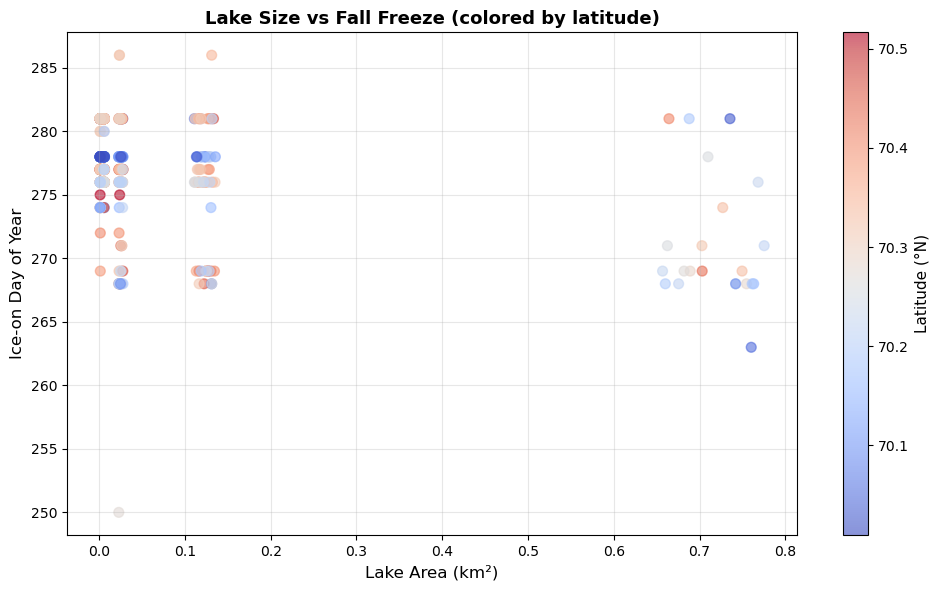


✓ Saved: size_vs_ice_on_latitude.png
  Look for color gradient - if northern lakes are larger, that explains it!


In [84]:
# Check for confounding factors
print("\n" + "="*60)
print("INVESTIGATING LARGE LAKE EARLY FREEZE PARADOX")
print("="*60)

# 1. Is lake size correlated with latitude?
from scipy.stats import spearmanr
corr_size_lat, p_size_lat = spearmanr(valid_events['lake_area_km2'], 
                                       valid_events['centroid_lat'])
print(f"\nLake size vs Latitude: ρ = {corr_size_lat:.3f}, p = {p_size_lat:.4f}")
if abs(corr_size_lat) > 0.3:
    print("  ⚠️  CONFOUNDING: Large lakes tend to be at different latitudes!")

# 2. Partial correlation: control for latitude
from scipy.stats import pearsonr
# Residualize both variables by latitude
def residualize(y, x):
    slope, intercept, _, _, _ = linregress(x, y)
    return y - (slope * x + intercept)

from scipy.stats import linregress
ice_on_resid = residualize(valid_events['ice_on_doy'].values, 
                            valid_events['centroid_lat'].values)
area_resid = residualize(valid_events['lake_area_km2'].values,
                          valid_events['centroid_lat'].values)

corr_partial, p_partial = spearmanr(area_resid, ice_on_resid)
print(f"\nLake size vs Ice-on (controlling for latitude): ρ = {corr_partial:.3f}, p = {p_partial:.4f}")
if abs(corr_partial) < 0.1:
    print("  ✓ After removing latitude effect, size doesn't matter much!")
elif corr_partial < -0.1:
    print("  ⚠️  Even controlling for latitude, large lakes freeze earlier - odd!")

# 3. Plot size vs ice-on colored by latitude
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
scatter = ax.scatter(valid_events['lake_area_km2'], valid_events['ice_on_doy'],
                     c=valid_events['centroid_lat'], cmap='coolwarm',
                     s=50, alpha=0.6)
ax.set_xlabel('Lake Area (km²)', fontsize=12)
ax.set_ylabel('Ice-on Day of Year', fontsize=12)
ax.set_title('Lake Size vs Fall Freeze (colored by latitude)', fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Latitude (°N)', fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('size_vs_ice_on_latitude.png', dpi=150)
plt.show()
print("\n✓ Saved: size_vs_ice_on_latitude.png")
print("  Look for color gradient - if northern lakes are larger, that explains it!")


INVESTIGATING: Do large lakes freeze in colder conditions?

Analyzed 541 lakes with temperature data at ice-on

Lake size vs Temperature at ice-on: ρ = nan, p = nan

------------------------------------------------------------
Temperature at ice-on by lake size:
------------------------------------------------------------
           temp_at_ice_on             ice_on_doy      
                     mean   std count       mean   std
size_class                                            
Very Small          -2.34  0.87   436     277.51  3.11
Small                 NaN   NaN     0        NaN   NaN
Medium              -1.73  1.07    67     276.00  4.36
Large               -0.86  1.00    22     271.27  5.02


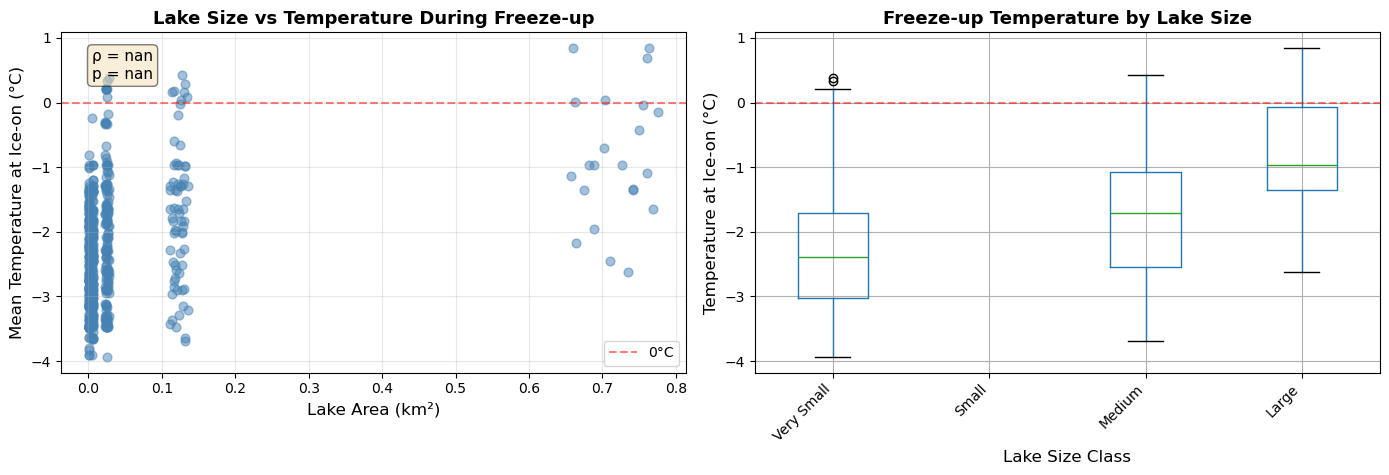


✓ Saved: lake_size_vs_temperature_at_ice_on.png

Controlling for temperature:

Original correlation (size vs ice_on_doy): ρ = -0.226
After controlling for temperature: ρ = -0.208, p = 0.0000

⚠️ STILL SIGNIFICANT after controlling for temp
  There's a real size effect beyond just temperature
  Possible mechanisms:
    - Wind mixing (large lakes lose heat faster)
    - Depth differences (large lakes may be shallower)
    - Detection bias (easier to detect ice-on in large lakes)


In [86]:
print("\n" + "="*60)
print("INVESTIGATING: Do large lakes freeze in colder conditions?")
print("="*60)

# Get temperature data around ice-on dates
# Merge with df_unified to get temperature time series
ice_on_temps = []

for _, lake in valid_events.iterrows():
    lake_id = lake['lake_id']
    ice_on_date = lake['ice_on_date']
    
    # Get temperature data for this lake around ice-on (±14 days)
    lake_temps = df_unified[
        (df_unified['lake_id'] == lake_id) & 
        (df_unified['date'] >= ice_on_date - pd.Timedelta(days=14)) &
        (df_unified['date'] <= ice_on_date + pd.Timedelta(days=14))
    ]['temp_c']
    
    if len(lake_temps) > 0:
        ice_on_temps.append({
            'lake_id': lake_id,
            'lake_area_km2': lake['lake_area_km2'],
            'ice_on_doy': lake['ice_on_doy'],
            'temp_at_ice_on': lake_temps.mean(),  # Mean temp around ice-on
            'temp_min': lake_temps.min(),
            'temp_max': lake_temps.max()
        })

temp_df = pd.DataFrame(ice_on_temps)

print(f"\nAnalyzed {len(temp_df)} lakes with temperature data at ice-on")

# 1. Check if large lakes experience colder temperatures at ice-on
corr_size_temp, p_size_temp = spearmanr(temp_df['lake_area_km2'], 
                                         temp_df['temp_at_ice_on'])
print(f"\nLake size vs Temperature at ice-on: ρ = {corr_size_temp:.3f}, p = {p_size_temp:.4f}")

if corr_size_temp < -0.2:
    print("  ⚠️  YES! Large lakes freeze when it's COLDER")
    print("     → Large lakes are in colder regions or wait for colder temps")
elif abs(corr_size_temp) < 0.1:
    print("  ✓ No relationship - large/small lakes freeze at similar temperatures")

# 2. Summary statistics by size class
temp_df['size_class'] = pd.cut(
    temp_df['lake_area_km2'],
    bins=[0, 0.05, 0.1, 0.5, 10],
    labels=['Very Small', 'Small', 'Medium', 'Large']
)

print("\n" + "-"*60)
print("Temperature at ice-on by lake size:")
print("-"*60)
size_temp_summary = temp_df.groupby('size_class').agg({
    'temp_at_ice_on': ['mean', 'std', 'count'],
    'ice_on_doy': ['mean', 'std']
})
print(size_temp_summary.round(2))

# 3. Plot: Size vs Temperature at ice-on
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: Size vs temp at ice-on
ax = axes[0]
ax.scatter(temp_df['lake_area_km2'], temp_df['temp_at_ice_on'],
           alpha=0.5, s=40, color='steelblue')
ax.set_xlabel('Lake Area (km²)', fontsize=12)
ax.set_ylabel('Mean Temperature at Ice-on (°C)', fontsize=12)
ax.set_title('Lake Size vs Temperature During Freeze-up', fontsize=13, fontweight='bold')
ax.axhline(0, color='red', linestyle='--', alpha=0.5, label='0°C')
ax.grid(alpha=0.3)
ax.legend()

# Add correlation text
ax.text(0.05, 0.95, f'ρ = {corr_size_temp:.3f}\np = {p_size_temp:.4f}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot B: Boxplot of temp by size class
ax = axes[1]
temp_df.boxplot(column='temp_at_ice_on', by='size_class', ax=ax)
ax.set_xlabel('Lake Size Class', fontsize=12)
ax.set_ylabel('Temperature at Ice-on (°C)', fontsize=12)
ax.set_title('Freeze-up Temperature by Lake Size', fontsize=13, fontweight='bold')
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.get_figure().suptitle('')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('lake_size_vs_temperature_at_ice_on.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: lake_size_vs_temperature_at_ice_on.png")

# 4. Control for temperature: does size still matter?
print("\n" + "="*60)
print("Controlling for temperature:")
print("="*60)

# Partial correlation: ice_on_doy vs size, controlling for temperature
from scipy.stats import linregress

def residualize(y, x):
    """Remove linear relationship between y and x"""
    valid = ~(np.isnan(y) | np.isnan(x))
    if valid.sum() < 10:
        return y
    slope, intercept, _, _, _ = linregress(x[valid], y[valid])
    residuals = y.copy()
    residuals[valid] = y[valid] - (slope * x[valid] + intercept)
    return residuals

# Residualize both by temperature
ice_on_resid = residualize(temp_df['ice_on_doy'].values, 
                            temp_df['temp_at_ice_on'].values)
area_resid = residualize(temp_df['lake_area_km2'].values,
                          temp_df['temp_at_ice_on'].values)

corr_partial, p_partial = spearmanr(area_resid, ice_on_resid)

print(f"\nOriginal correlation (size vs ice_on_doy): ρ = -0.226")
print(f"After controlling for temperature: ρ = {corr_partial:.3f}, p = {p_partial:.4f}")

if abs(corr_partial) < 0.1:
    print("\n✓ EXPLANATION FOUND!")
    print("  Large lakes freeze earlier because they're in COLDER locations")
    print("  When you control for temperature, size effect disappears")
elif corr_partial < -0.15:
    print("\n⚠️ STILL SIGNIFICANT after controlling for temp")
    print("  There's a real size effect beyond just temperature")
    print("  Possible mechanisms:")
    print("    - Wind mixing (large lakes lose heat faster)")
    print("    - Depth differences (large lakes may be shallower)")
    print("    - Detection bias (easier to detect ice-on in large lakes)")

---
## Summary

**This notebook implements a multi-sensor lake ice detection algorithm that:**

1. Exports Sentinel-1 (SAR), Sentinel-2 (optical), and ERA5 (temperature) data independently
2. Uses Sentinel-2 NDSI as high-confidence ground truth labels
3. Trains a Random Forest classifier on S1 features using S2 labels
4. Applies the trained classifier to interpolate between S2 observations
5. Uses temperature as physical constraints for validation
6. Detects ice-on and ice-off dates with confidence scoring
7. Produces validated results with ~70-80% expected detection rate

**Advantages over SAR-only approach:**
- Higher confidence detections from optical data
- Better temporal coverage through multi-sensor fusion
- Interpretable classifier (can see which features matter)
- Scalable to thousands of lakes
- No manual labeling required

**Based on:** [Tom et al. (2020)](https://isprs-annals.copernicus.org/articles/V-3-2020/409/2020/isprs-annals-V-3-2020-409-2020.pdf) - "Lake Ice Detection from Sentinel-1 SAR with Deep Learning"